# THis analysis is to extract the strains in the different zones of the image.
## The strain field is already calculated using the multipass piv method in the file analysis_RTV_STODV1_3scotch_box1_test1. 
## I try to segment the image intp debonded area and bonded area by drawing a polygon around the debonded zone using points added manually.
### Note that most model have one calculation and then the iteration over all the time frames
### I can calculate the area and the characteristic length of the debonded zone from this
## Another module helps to draw a rectangle in the zone (bonded or unbonded) to calculate the local average strain
### For the experiment 20240515_box2_rtv_3scotch_try1, I have done measuements at multiple piv resolution and obtained the same result, So here I do all the calculations only for windowsize [128  64  32] and overlap [32 16 16] pixels 
## I then input these calculations into my model to extract the adhesion energy


In [6]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv 
from scipy.ndimage import gaussian_filter
from skimage import measure
from skimage.color import label2rgb
import pandas as pd
from skimage.filters import threshold_multiotsu
from skimage import morphology
from skimage import util 
from skimage.util import map_array
import pathlib
import importlib_resources
from time import time
import warnings

from skimage import transform
from nd2reader import ND2Reader
from scipy.ndimage.filters import gaussian_filter, gaussian_filter1d

import h5py
import math
from matplotlib.patches import Circle
import matplotlib.patches as patches
from rich.console import Console
console = Console()

# Import the ScaleBar class
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.font_manager as fm

%matplotlib inline


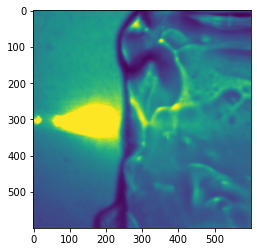

In [2]:
im = cv.imreadmulti(r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\crop_VCXU-32M_700002909206_240515-184255.tif")
imgray = cv.cvtColor(im[1][35], cv.COLOR_BGR2GRAY)
plt.imshow(imgray)
fil_im = gaussian_filter(imgray-gaussian_filter(imgray.astype(float), 101),1)

## The segmentation and labelling method did not work for these camera images. I try to manually pick points and draw a polygon
- I open the image and click on the boundary to generate points.
- I store the points and also generate an image with a polygon drwan using the points
- I also click on two points to get the characteristic length of debonding 

In [5]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from scipy.ndimage import gaussian_filter
%matplotlib auto

# Pixel sizes for camera and confocal (placeholders, should be replaced with actual values)
px_size_camera = 3.481e-6

# List to store points clicked on the image
points = []

# Function to handle mouse click events
def onclick(event):
    if event.inaxes == ax:  # Ensure the click is within the image axes
        if event.xdata and event.ydata:  # Ensure the click is within the image bounds
            points.append((int(event.xdata), int(event.ydata)))  # Add the clicked point to the list
            ax.plot(event.xdata, event.ydata, 'ro')  # Plot the point on the image
            fig.canvas.draw()  # Update the figure

# Function to reset the points and clear the image
def reset(event):
    global points
    points = []  # Clear the list of points
    ax.clear()  # Clear the current image
    ax.imshow(fil_im)  # Display the original filtered image
    fig.canvas.draw()  # Update the figure

# Function to fit a polygon around the clicked points and calculate its area
def fit_polygon(event):
    if len(points) > 2:  # Ensure there are enough points to form a polygon
        pts = np.array(points, np.int32)  # Convert points to numpy array
        pts = pts.reshape((-1, 1, 2))  # Reshape for OpenCV function
        fil_im_copy = fil_im.copy()  # Make a copy of the filtered image
        cv.polylines(fil_im_copy, [pts], isClosed=True, color=(255, 0, 0), thickness=2)  # Draw the polygon
        ax.clear()  # Clear the current image
        ax.imshow(fil_im_copy)  # Display the image with the polygon
        fig.canvas.draw()  # Update the figure

        # Calculate the area of the polygon
        area_pixels = cv.contourArea(pts)
        area_microns = area_pixels * (px_size_camera ** 2)
        print(f'Polygon area: {area_pixels:.2f} pixels, {area_microns:.2e} square microns')

        # Save the image with the drawn polygon
        save_image(fil_im_copy, 'polygon_image.png')

        plt.close(fig)  # Close the polygon fitting window
        measure_length()  # Open the length measurement window automatically

# Function to save the image with the drawn polygon
def save_image(image, filename):
    save_path = filename  # Path to save the image
    image_norm = cv.normalize(image, None, 0, 1, cv.NORM_MINMAX, dtype=cv.CV_32F)
    plt.imsave(filename, image_norm, cmap='viridis')
    ##cv.imwrite(save_path, image)  # Save the image
    print(f'Image saved as {save_path}')

# Function to measure the length between two points
def measure_length():
    length_points = []

    def onclick_length(event):
        if event.inaxes == ax_length:  # Ensure the click is within the image axes
            if event.xdata and event.ydata:  # Ensure the click is within the image bounds
                length_points.append((int(event.xdata), int(event.ydata)))  # Add the clicked point to the list
                ax_length.plot(event.xdata, event.ydata, 'go')  # Plot the point on the image with a different color
                fig_length.canvas.draw()  # Update the figure
                if len(length_points) == 2:  # If two points are selected, calculate and display the length
                    calculate_length(length_points)

    def calculate_length(points):
        pt1, pt2 = points
        length_pixels = np.sqrt((pt2[0] - pt1[0]) ** 2 + (pt2[1] - pt1[1]) ** 2)
        length_microns = length_pixels * px_size_camera
        print(f'Length: {length_pixels:.2f} pixels, {length_microns:.2e} microns')

        # Draw the line on the image
        fil_im_copy_length = fil_im.copy()  # Make a copy of the filtered image
        cv.line(fil_im_copy_length, pt1, pt2, (0, 255, 0), thickness=2)
        ax_length.clear()
        ax_length.imshow(fil_im_copy_length)
        fig_length.canvas.draw()

        # Save the image with the drawn line
        save_image(fil_im_copy_length, 'line_image.png')
        
        plt.close(fig_length)  # Close the length measurement window after calculation

    # Display the image in a new window
    fig_length, ax_length = plt.subplots()
    ax_length.imshow(fil_im)
    fig_length.canvas.mpl_connect('button_press_event', onclick_length)
    plt.show()

# Load the image and process it
im = cv.imreadmulti(r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\crop_VCXU-32M_700002909206_240515-184255.tif")
imgray = cv.cvtColor(im[1][40], cv.COLOR_BGR2GRAY)  # Convert to grayscale
#plt.imshow(imgray)
fil_im = gaussian_filter(imgray - gaussian_filter(imgray.astype(float), 101), 1)  # Apply Gaussian filter

# Display the image using Matplotlib
fig, ax = plt.subplots()
ax.imshow(fil_im)
cid = fig.canvas.mpl_connect('button_press_event', onclick)  # Connect the click event for polygon

# Add buttons for reset, fit polygon, and measure length
reset_ax = plt.axes([0.0, 0.0, 0.1, 0.075])
fit_ax = plt.axes([0.15, 0.0, 0.1, 0.075])
reset_button = Button(reset_ax, 'Reset')
fit_button = Button(fit_ax, 'Fit Polygon')
reset_button.on_clicked(reset)  # Connect the reset button to the reset function
fit_button.on_clicked(fit_polygon)  # Connect the fit button to the fit polygon function

plt.show()


Using matplotlib backend: Qt5Agg
Polygon area: 80760.50 pixels, 9.79e-07 square microns
Image saved as polygon_image.png
Length: 231.04 pixels, 8.04e-04 microns
Image saved as line_image.png


### Iteration of the above over multiple image and saving the points and image
- the debonding start from t= 29s but the image is not so clear. Also it proceed to t = 56 but at t = 46 it extends beyond the image.  So I will for time 36s to 46s when we see debonding in progress
- Saving image of camera with polygon drawn, as well image of line, length of the line (c) and the area of the polygon

In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from scipy.ndimage import gaussian_filter
%matplotlib auto

# Pixel sizes for camera in um
px_size_camera = 3.481e-6

# Directory to save the output
save_dir = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\camera_polygon"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Function to handle mouse click events
def onclick(event):
    if event.inaxes == ax:  # Ensure the click is within the image axes
        if event.xdata and event.ydata:  # Ensure the click is within the image bounds
            points.append((int(event.xdata), int(event.ydata)))  # Add the clicked point to the list
            ax.plot(event.xdata, event.ydata, 'ro')  # Plot the point on the image
            fig.canvas.draw()  # Update the figure

# Function to reset the points and clear the image
def reset(event):
    global points
    points = []  # Clear the list of points
    ax.clear()  # Clear the current image
    ax.imshow(fil_im)  # Display the original filtered image
    fig.canvas.draw()  # Update the figure

# Function to fit a polygon around the clicked points and calculate its area
def fit_polygon(event):
    if len(points) > 2:  # Ensure there are enough points to form a polygon
        pts = np.array(points, np.int32)  # Convert points to numpy array
        pts = pts.reshape((-1, 1, 2))  # Reshape for OpenCV function
        fil_im_copy = fil_im.copy()  # Make a copy of the filtered image
        cv.polylines(fil_im_copy, [pts], isClosed=True, color=(255, 0, 0), thickness=2)  # Draw the polygon
        ax.clear()  # Clear the current image
        ax.imshow(fil_im_copy)  # Display the image with the polygon
        fig.canvas.draw()  # Update the figure

        # Calculate the area of the polygon
        area_pixels = cv.contourArea(pts)
        area_microns = area_pixels * (px_size_camera ** 2)
        print(f'Polygon area: {area_pixels:.2f} pixels, {area_microns:.2e} square microns')

        # Save the image with the drawn polygon
        save_image(fil_im_copy, f'polygon_image_t{t}_try_2.png')

        # Save the area data
        with open(os.path.join(save_dir, 'polygon_areas_try_2.txt'), 'a') as f:
            f.write(f'Time {t}: {area_pixels:.2f} pixels, {area_microns:.2e} square microns\n')

        # Save the points for the polygon
        with open(os.path.join(save_dir, f'points_polygon_t{t}_try_2.txt'), 'w') as f:
            for point in points:
                f.write(f'{point}\n')

        plt.close(fig)  # Close the polygon fitting window
        measure_length(t, fil_im)  # Open the length measurement window automatically with the correct image

# Function to save the image with the drawn polygon
def save_image(image, filename):
    save_path = os.path.join(save_dir, filename)  # Path to save the image
    image_norm = cv.normalize(image, None, 0, 1, cv.NORM_MINMAX, dtype=cv.CV_32F)
    plt.imsave(save_path, image_norm, cmap='viridis')
    print(f'Image saved as {save_path}')

# Global list to store all line segments
previous_lines = []

# Function to measure the length between two points
def measure_length(t, fil_im):
    length_points = []

    def onclick_length(event):
        if event.inaxes == ax_length:  # Ensure the click is within the image axes
            if event.xdata and event.ydata:  # Ensure the click is within the image bounds
                length_points.append((int(event.xdata), int(event.ydata)))  # Add the clicked point to the list
                ax_length.plot(event.xdata, event.ydata, 'go')  # Plot the point on the image with a different color
                fig_length.canvas.draw()  # Update the figure
                if len(length_points) == 2:  # If two points are selected, calculate and display the length
                    calculate_length(length_points, t)

    def calculate_length(points, t):
        pt1, pt2 = points
        length_pixels = np.sqrt((pt2[0] - pt1[0]) ** 2 + (pt2[1] - pt1[1]) ** 2)
        length_microns = length_pixels * px_size_camera
        print(f'Length: {length_pixels:.2f} pixels, {length_microns:.2e} microns')

        # Draw the line on the image
        fil_im_copy_length = fil_im.copy()  # Make a copy of the filtered image
        cv.line(fil_im_copy_length, pt1, pt2, (255, 0, 0), thickness=2)  # Draw the line in red
        ax_length.clear()
        ax_length.imshow(fil_im_copy_length)
        fig_length.canvas.draw()

        # Save the image with the drawn line
        save_image(fil_im_copy_length, f'line_image_t{t}.png')
        
        plt.close(fig_length)  # Close the length measurement window after calculation

        # Save the length data
        with open(os.path.join(save_dir, 'lengths_try2.txt'), 'a') as f:
            f.write(f'Time {t}: {length_pixels:.2f} pixels, {length_microns:.2e} microns\n')

        # Add the line to the global list of previous lines
        previous_lines.append((pt1, pt2))

    # Display the image in a new window
    fig_length, ax_length = plt.subplots()
    ax_length.imshow(fil_im)

    # Draw all previous lines on the image
    for line in previous_lines:
        pt1, pt2 = line
        cv.line(fil_im, pt1, pt2, (255, 0, 0), thickness=2)  # Draw previous lines in red

    ax_length.imshow(fil_im)  # Display the image with all previous lines
    fig_length.canvas.mpl_connect('button_press_event', onclick_length)
    plt.show()

# Load the image stack and process each time frame
ret, im = cv.imreadmulti(r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\crop_VCXU-32M_700002909206_240515-184255.tif")

ti = 36  # Start of debonding
tf = 46  # Stop of debonding
gauss_bg = 101  # Background Gaussian filter size
gauss_ns = 1  # Noise suppression Gaussian filter size

for t in range(ti, tf):  # Loop through each time frame
    imgray = cv.cvtColor(im[t], cv.COLOR_BGR2GRAY)  # Convert to grayscale
    fil_im = gaussian_filter(imgray - gaussian_filter(imgray.astype(float), gauss_bg), gauss_ns)  # Apply Gaussian filter

    # Reset points for each new frame
    points = []

    # Display the image using Matplotlib
    fig, ax = plt.subplots()
    ax.imshow(fil_im)
    cid = fig.canvas.mpl_connect('button_press_event', onclick)  # Connect the click event for polygon

    # Add buttons for reset, fit polygon, and measure length
    reset_ax = plt.axes([0.0, 0.0, 0.1, 0.075])
    fit_ax = plt.axes([0.15, 0.0, 0.1, 0.075])
    reset_button = Button(reset_ax, 'Reset')
    fit_button = Button(fit_ax, 'Fit Polygon')
    reset_button.on_clicked(reset)  # Connect the reset button to the reset function
    fit_button.on_clicked(fit_polygon)  # Connect the fit button to the fit polygon function

    plt.show(block=True)  # Wait until the window is closed before continuing to the next frame


Using matplotlib backend: Qt5Agg
Polygon area: 40229.00 pixels, 4.87e-07 square microns
Image saved as D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\camera_polygon\polygon_image_t36_try_2.png
Polygon area: 43155.00 pixels, 5.23e-07 square microns
Image saved as D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\camera_polygon\polygon_image_t37_try_2.png
Length: 100.12 pixels, 3.49e-04 microns
Image saved as D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\camera_polygon\line_image_t36.png
Length: 109.64 pixels, 3.82e-04 microns
Image saved as D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\camera_polygon\line_image_t37.png
Polygon area: 62032.00 pixels, 7.52e-07 square microns
Image saved as D:\ESPCI\Experiments\mechanoconfo

## Draw the points into a polygon overlayed over the confocal image

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from nd2reader import ND2Reader

# Load points from the previous polygon drawing
points_array = np.array(points)

# Load the new image and metadata
im1 = ND2Reader(r"sample_rtv_20240514_box1_stodv1_scotch3_test_1.nd2")[38]
px_size_confocal = im1.metadata['pixel_microns'] * 1e-06  # Pixel size

# Convert the points to match the new confocal image's scale
points_array_conf = px_size_camera * points_array / px_size_confocal

# Clip values to be within the range [0, 511]
points_array_conf = np.clip(points_array_conf, 0, im1.shape[0])

# Convert to integers
points_array_conf = points_array_conf.astype(np.int32)

# Reshape points for polylines
points_array_conf = points_array_conf.reshape((-1, 1, 2))

# Ensure the image is in the correct format for OpenCV
im1_copy = np.array(im1, dtype=np.uint8)  # Make a copy of the image

# Draw the polygon on the new image
cv.polylines(im1_copy, [points_array_conf], isClosed=True, color=(255, 0, 0), thickness=2)

# Display the image
plt.imshow(im1_copy, cmap='viridis')
plt.show()




In [229]:
points_array.shape

(17, 2)

### Iterate over time to draw on the confocal image

In [4]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from nd2reader import ND2Reader

# Pixel sizes for camera in um
px_size_camera = 3.481e-6

# Directory where the points files are saved
points_dir = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\camera_polygon"

# Directory to save the output images
save_dir = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\confocal_polygon"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Load the ND2 file
nd2_file = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\sample_rtv_20240514_box1_stodv1_scotch3_test_1.nd2"
nd2_reader = ND2Reader(nd2_file)

# Function to read points from the text file for a given frame
def read_points_from_file(frame):
    points_file = os.path.join(points_dir, f'points_polygon_t{frame}_try_2.txt')
    points = []
    with open(points_file, 'r') as f:
        for line in f:
            point = line.strip().strip('()').split(',')
            points.append((int(point[0]), int(point[1])))
    return np.array(points)

# Function to scale and draw polygons on the image, and save the image
def draw_polygon_on_image(im, points, px_size_confocal, frame, save_dir):
    points_array_conf = px_size_camera * points / px_size_confocal
    points_array_conf = np.clip(points_array_conf, 0, im.shape[0] - 1)
    points_array_conf = points_array_conf.astype(np.int32)
    points_array_conf = points_array_conf.reshape((-1, 1, 2))

    im_copy = np.array(im, dtype=np.uint8)
    cv.polylines(im_copy, [points_array_conf], isClosed=True, color=(255, 0, 0), thickness=2)

    plt.imshow(im_copy, cmap='viridis')
    plt.title(f'Frame {frame}')
    plt.show()

    # Save the image
    save_path = os.path.join(save_dir, f'polygon_image_frame_{frame}.png')
    cv.imwrite(save_path, im_copy)
    print(f'Image saved as {save_path}')

# Iterate over frames and plot the polygons
ti = 36  # Start frame
tf = 46  # End frame

for t in range(ti, tf):
    # Read points from the text file for the current frame
    points = read_points_from_file(t)

    # Load the confocal image for the current frame
    im = nd2_reader[t]
    px_size_confocal = im.metadata['pixel_microns'] * 1e-06

    # Draw the polygon on the image and save it
    draw_polygon_on_image(im, points, px_size_confocal, t, save_dir)


Image saved as D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\confocal_polygon\polygon_image_frame_36.png
Image saved as D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\confocal_polygon\polygon_image_frame_37.png
Image saved as D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\confocal_polygon\polygon_image_frame_38.png
Image saved as D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\confocal_polygon\polygon_image_frame_39.png
Image saved as D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\confocal_polygon\polygon_image_frame_40.png
Image saved as D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\

## Draw the polygon enclosing the point onto the strain_field array

In [7]:
%matplotlib auto

im1 = ND2Reader(r"sample_rtv_20240514_box1_stodv1_scotch3_test_1.nd2") # Read ND2 file

# Set the pixel size
px = np.array([im1.metadata['pixel_microns']*1e-06, im1.metadata['pixel_microns']*1e-06])  # Pixel size

# Set the time indices
ti = 36 #
tf = 46 #12 less again to avoid the issue of bad correlation
t = 40

# Calculate the time difference
dt = (im1.timesteps[40] - im1.timesteps[39]) * 1e-3

##20240515_tensile0.005_RTV_1mm_scotch_3_test_1_multiscale3_w32_ol8.h5, 20240515_tensile0.005_RTV_1mm_scotch_3_test_1_multiscale3_w32_ol16_nointen_thresh.h5
with h5py.File('20240515_tensile0.005_RTV_box1_1mm_scotch_3_test_1_multiscale3_w32_ol16.h5', 'r') as h5file:
    ls = list(h5file.keys())
    data = h5file.get('FlowField')
    atts = dict(data.attrs)
    ws = atts['window_size'][-1]
    os = atts['overlap_size'][-1]

    

    # Read the gradient field and flow field arrays at time index t1
    grad_array = h5file.get('gradient_field')[ti:t].sum(axis = 0)*dt 
    # Calculate strain field and rotation field
    strain_field = 0.5 * (grad_array + grad_array.transpose(0, 1, 3, 2))

    # Convert the points to match the the strain image's scale 
    points_array_strain = px_size_camera * points_array / (px_size_confocal*(ws-os))

    # Clip values to be within the range [0, 511]
    points_array_strain = np.clip(points_array_strain, 0, strain_field.shape[0])

    # Convert to integers
    points_array_strain = points_array_strain.astype(np.int32)

    # Reshape points for polylines
    points_array_strain = points_array_strain.reshape((-1, 1, 2))

    # Ensure the image is in the correct format for OpenCV
    im1_copy = np.array(im1, dtype=np.uint8)  # Make a copy of the image



    # Plot norm and trace of strain fields
    fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
    subplot_titles = [r'|$\epsilon_{xx}|$', r'tr($\epsilon_{yx}$)']
    norm_strain = np.linalg.norm(strain_field, axis=(-2, -1))
    # Ensure the image is in the correct format for OpenCV
    norm_strain_copy = np.array(norm_strain)  # Make a copy of the image

    # Draw the polygon on the new image: does not work
    ###cv.polylines(norm_strain_copy, [points_array], isClosed=True, color=(0, 255, 0), thickness=2)
    
    vv =0.3
    im11 = axs.imshow(norm_strain_copy, vmin=0, vmax=vv)  #, extent=(0, im1.shape[1], im1.shape[1],0)
    
    axs.plot(points_array_strain[..., 0], points_array_strain[..., 1], 'r-', linewidth=2) 
    # Add text annotation
    axs.text(0.05, 0.95, 't = {:.2f} s'.format(t*dt), fontsize=16, color='white', ha='left', va='top', transform=axs.transAxes)
    axs.set_title(r'|$\epsilon_{xx}|$', fontsize=16)
    fig.colorbar(im11, ax=axs, shrink=0.5)  # Include mappable parameter and ax
    #axs.axis('off')

Using matplotlib backend: Qt5Agg


In [217]:
512/(ws-os)

32.0

### Iterate over the h5 file to draw the polygon over the norm of strain at different time
- I run this module again but with modified_points

In [39]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from nd2reader import ND2Reader
import h5py

%matplotlib auto

# Paths to the necessary files
nd2_file = rnd2_file = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\sample_rtv_20240514_box1_stodv1_scotch3_test_1.nd2"
#points_dir = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\camera_polygon"
points_dir = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8\confocal_polygon\modified_points"
h5_file =  r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\20240515_tensile0.005_RTV_box1_1mm_scotch_3_test_1_multiscale3_w32_ol8.h5"

# Directory to save the output images
save_dir = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8\strain_norm_polygon"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Load the ND2 file
im1 = ND2Reader(nd2_file)

# Set the pixel size
px_size_camera = 3.481e-6  # Pixel size in meters
px_size_confocal = im1.metadata['pixel_microns'] * 1e-06  # Pixel size in meters

# Set the time indices
ti = 36
tf = 46  # 12 less again to avoid the issue of bad correlation
dt = (im1.timesteps[40] - im1.timesteps[39]) * 1e-3

# Function to read points from the text file for a given frame
def read_points_from_file(frame):
    points_file = os.path.join(points_dir, f'points_modified_polygon_t{frame}.txt')
#    points_file = os.path.join(points_dir, f'points_modified_polygon_t{frame}.txt')
    points = []
    with open(points_file, 'r') as f:
        for line in f:
            point = line.strip().strip('()').split(',')
            points.append((int(point[0]), int(point[1])))
    return np.array(points)



# Function to draw polygon on the strain field and save the image
def draw_and_save_polygon_on_strain_field(frame, points, px_size_confocal, strain_field, save_dir):
    with h5py.File(h5_file, 'r') as h5file:
            ls = list(h5file.keys())
            data = h5file.get('FlowField')
            atts = dict(data.attrs)
            ws = atts['window_size'][-1]
            ol = atts['overlap_size'][-1]
            
    points_array_strain = px_size_camera * points / (px_size_confocal * (ws - ol))
    points_array_strain = np.clip(points_array_strain, 0, strain_field.shape[0])
    points_array_strain = points_array_strain.astype(np.int32)
    points_array_strain = points_array_strain.reshape((-1, 1, 2))

    norm_strain = np.linalg.norm(strain_field, axis=(-2, -1))
    norm_strain_copy = np.array(norm_strain)  # Make a copy of the image

    fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
    vv = 0.3
    im11 = axs.imshow(norm_strain_copy, vmin=0, vmax=vv)
    axs.plot(points_array_strain[..., 0], points_array_strain[..., 1], 'r-', linewidth=2)
    axs.text(0.05, 0.95, f't = {frame * dt:.2f} s', fontsize=16, color='white', ha='left', va='top', transform=axs.transAxes)
    axs.set_title(r'||$\epsilon_{xx}||_{F}$', fontsize=16)
    fig.colorbar(im11, ax=axs, shrink=0.5)
    axs.axis('off')

    save_path = os.path.join(save_dir, f'modified_strain_mag_polygon_frame_{frame}.png')
    plt.savefig(save_path)
    print(f'Image saved as {save_path}')
    plt.close(fig)

# Iterate over frames
for t in range(ti, tf):
    # Open the H5 file and read the necessary data
    with h5py.File(h5_file, 'r') as h5file:
        gradient_field = h5file.get('gradient_field')[ti:t+1]
        grad_array_sum = gradient_field.sum(axis=0) * dt
        strain_field = 0.5 * (grad_array_sum + grad_array_sum.transpose(0, 1, 3, 2))

    # Read points from the text file for the current frame
    points = read_points_from_file(t)

    # Draw the polygon on the strain field and save the image
    draw_and_save_polygon_on_strain_field(t, points, px_size_confocal, strain_field, save_dir)


Using matplotlib backend: Qt5Agg
Image saved as D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8\strain_norm_polygon\modified_strain_mag_polygon_frame_36.png
Image saved as D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8\strain_norm_polygon\modified_strain_mag_polygon_frame_37.png
Image saved as D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8\strain_norm_polygon\modified_strain_mag_polygon_frame_38.png
Image saved as D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8\strain_norm_polygon\modified_strain_mag_polygon_frame_39.png
Image saved as D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8\strain_norm_polygon\modified_strain_mag_polygon_frame_40.png
Image saved as D:

In [69]:
ol, ws

(16, 32)

## From the overlay of polygon and the strain, I approximate that the polygon should be shifted approximately to correspond to the confocal image

In [9]:
import os
import numpy as np

h5_file =  r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\20240515_tensile0.005_RTV_box1_1mm_scotch_3_test_1_multiscale3_w32_ol16.h5"

# Set the pixel size
px_size_camera = 3.481e-6  # Pixel size in meters
px_size_confocal = im1.metadata['pixel_microns'] * 1e-06  # Pixel size in meters

with h5py.File(h5_file, 'r') as h5file:
        ls = list(h5file.keys())
        data = h5file.get('FlowField')
        atts = dict(data.attrs)
        ws = atts['window_size'][-1]
        ol = atts['overlap_size'][-1]

# Directory containing the original point files
points_dir = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\camera_polygon"

# Directory to save the modified point files
modified_points_dir = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\confocal_polygon\modified_points"
if not os.path.exists(modified_points_dir):
    os.makedirs(modified_points_dir)

# Set the time indices
ti = 36
tf = 46

# Shift values
shift_x = 60#int(-1*(ws-ol)*px_size_confocal/px_size_camera)  # Shift value for x coordinates
shift_y = 0  # Shift value for y coordinates

print("The x and y shift are {} {}".format(shift_x,shift_y))

# Function to read points from the text file for a given frame
def read_points_from_file(frame):
    points_file = os.path.join(points_dir, f'points_polygon_t{frame}_try_2.txt')
    points = []
    with open(points_file, 'r') as f:
        for line in f:
            point = line.strip().strip('()').split(',')
            points.append((int(point[0]), int(point[1])))
    return np.array(points)

# Function to save modified points to a new text file
def save_modified_points_to_file(frame, modified_points):
    modified_points_file = os.path.join(modified_points_dir, f'points_modified_polygon_t{frame}.txt')
    with open(modified_points_file, 'w') as f:
        for point in modified_points:
            f.write(f'({point[0]}, {point[1]})\n')

# Iterate over frames
for t in range(ti, tf):
    # Read points from the text file for the current frame
    points = read_points_from_file(t)

    # Apply the shift to the points
    modified_points = points + np.array([shift_x, shift_y])

    # Save the modified points to a new text file
    save_modified_points_to_file(t, modified_points)

print("Points have been successfully shifted and saved to new files.")


The x and y shift are 60 0
Points have been successfully shifted and saved to new files.


## Create a mask to isolate the zone enclosed by the points in the norm strain array. I an later make the code for particular strain component but for now I concentrate on just the norm
- First I create a zero mask that covers the entire image
- Fill the polygon region inside the points with 1
- Use the mask to select the polynomial region to compute for example the norm

In [40]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import h5py
from nd2reader import ND2Reader

# Read ND2 file
im1 = ND2Reader(r"sample_rtv_20240514_box1_stodv1_scotch3_test_1.nd2")

# Set the pixel size
px = np.array([im1.metadata['pixel_microns'] * 1e-06, im1.metadata['pixel_microns'] * 1e-06])  # Pixel size

# Set the time indices
ti = 36
tf = 46
t = 40

# Calculate the time difference
dt = (im1.timesteps[40] - im1.timesteps[39]) * 1e-3

# Load HDF5 data
with h5py.File('20240515_tensile0.005_RTV_box1_1mm_scotch_3_test_1_multiscale3_w32_ol8.h5', 'r') as h5file:
    ls = list(h5file.keys())
    data = h5file.get('FlowField')
    atts = dict(data.attrs)
    ws = atts['window_size'][-1]
    os = atts['overlap_size'][-1]

    # Read gradient field and calculate strain field
    grad_array = h5file.get('gradient_field')[ti:t].sum(axis=0) * dt
    strain_field = 0.5 * (grad_array + grad_array.transpose(0, 1, 3, 2))
    norm_strain = np.linalg.norm(strain_field, axis=(-2, -1))

    # Convert the points to match the strain image's scale
    points_array_strain = px_size_camera * points_array / (px_size_confocal * (ws - os))

    # Clip values to be within the range [0, strain_field.shape[0]]
    points_array_strain = np.clip(points_array_strain, 0, strain_field.shape[0])

    # Convert to integers
    points_array_strain = points_array_strain.astype(np.int32)

    # Reshape points for polylines
    points_array_strain = points_array_strain.reshape((-1, 1, 2))

    # Create a mask of the same size as the strain_field
    mask = np.zeros((norm_strain.shape[0], norm_strain.shape[1]), dtype=np.uint8)

    # Fill the polygon in the mask
    cv.fillPoly(mask, [points_array_strain], 1)

    # Use the mask to calculate the average value inside the polygon
    masked_norm_strain_field = norm_strain*mask ###strain_field[:, :, 0, 0] * mask  # Assuming you're interested in a specific component, e.g., epsilon_xx
    masked_values = masked_norm_strain_field[mask == 1]

    plt.imshow(masked_norm_strain_field)
    # Calculate the average
    average_value = np.mean(masked_values)
    print(f'Average value inside the polygon: {average_value}')





Average value inside the polygon: 0.03599812835454941


In [11]:
masked_values.shape

(353,)

#### Do the calculation for the modified points and iterate over all the debonded images
- Saving the average Frobenius norm of the strain as well
- Saving the average of the square value of the norm of strain to extract the strain energy
- Note we can also calculate the average strain energy using square of hte average of the strain. The method above will capture the variance  since $mean(x_{i}^2) = (mean(x_{i}))^2 + \sigma^{2}$ where $\sigma$ is the variance

In [43]:
import os
import cv2 as cv
import numpy as np
import h5py
from nd2reader import ND2Reader

# Directories
points_dir = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8\confocal_polygon\modified_points"
output_dir = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Read ND2 file
im1 = ND2Reader(r"sample_rtv_20240514_box1_stodv1_scotch3_test_1.nd2")

# Set the pixel size
px_size_confocal = im1.metadata['pixel_microns'] * 1e-06  # Pixel size
px_size_camera = 3.481e-6

# Set the time indices
ti = 36
tf = 46

# Function to read points from the modified polygon text file for a given frame
def read_modified_points_from_file(frame):
    points_file = os.path.join(points_dir, f'points_modified_polygon_t{frame}.txt')
    points = []
    with open(points_file, 'r') as f:
        for line in f:
            point = line.strip().strip('()').split(',')
            points.append((int(point[0]), int(point[1])))
    return np.array(points)

# Output files for average strain energy and average strain
average_strain_energy_file = os.path.join(output_dir, 'debonded_average_strain_energy.txt')
average_strain_file = os.path.join(output_dir, 'debonded_average_strain.txt')


with open(average_strain_file, 'w') as f_strain, open(average_strain_energy_file, 'w') as f_energy:
    # Iterate over frames
    for t in range(ti, tf):
        # Calculate the time difference
        dt = (im1.timesteps[t] - im1.timesteps[t-1]) * 1e-3

        # Load HDF5 data
        with h5py.File('20240515_tensile0.005_RTV_box1_1mm_scotch_3_test_1_multiscale3_w32_ol8.h5', 'r') as h5file:
            data = h5file.get('FlowField')
            atts = dict(data.attrs)
            ws = atts['window_size'][-1]
            ol = atts['overlap_size'][-1]

            # Read gradient field and calculate strain field
            grad_array = h5file.get('gradient_field')[ti:t].sum(axis=0) * dt
            strain_field = 0.5 * (grad_array + grad_array.transpose(0, 1, 3, 2))
            norm_strain = np.linalg.norm(strain_field, axis=(-2, -1))

            # Read modified points for the current frame
            points = read_modified_points_from_file(t)

            # Convert the points to match the strain image's scale
            points_array_strain = px_size_camera * points / (px_size_confocal * (ws - ol))

            # Clip values to be within the range [0, strain_field.shape[0]]
            points_array_strain = np.clip(points_array_strain, 0, strain_field.shape[0])

            # Convert to integers
            points_array_strain = points_array_strain.astype(np.int32)

            # Reshape points for polylines
            points_array_strain = points_array_strain.reshape((-1, 1, 2))

            # Create a mask of the same size as the strain_field
            mask = np.zeros((norm_strain.shape[0], norm_strain.shape[1]), dtype=np.uint8)

            # Fill the polygon in the mask
            cv.fillPoly(mask, [points_array_strain], 1)

            # Use the mask to calculate the average value inside the polygon
            masked_norm_strain_field = norm_strain * mask
            masked_values = masked_norm_strain_field[mask == 1]

            # Calculate the average of the square of the strain values (strain energy). Should be the same as square of the average strain since norm strain is a positve matrix
            average_strain_energy = np.mean(masked_values ** 2)

            # Calculate the average strain
            average_strain = np.mean(masked_values)

            # Save the average strain energy and average strain to the respective files
            f_energy.write(f'Time {t}: {average_strain_energy:.6e}\n')
            f_strain.write(f'Time {t}: {average_strain:.6e}\n')

            print(f'Frame {t} - Average strain energy in debonded: {average_strain_energy:.6e}, Average strain debonded: {average_strain:.6e}')

    print("Calculation and saving of strain energy and average strain completed.")


Frame 36 - Average strain energy in debonded: 0.000000e+00, Average strain debonded: 0.000000e+00
Frame 37 - Average strain energy in debonded: 4.889275e-04, Average strain debonded: 1.876274e-02
Frame 38 - Average strain energy in debonded: 1.257720e-03, Average strain debonded: 2.792951e-02
Frame 39 - Average strain energy in debonded: 2.131684e-03, Average strain debonded: 3.721023e-02
Frame 40 - Average strain energy in debonded: 2.663392e-03, Average strain debonded: 4.198994e-02
Frame 41 - Average strain energy in debonded: 3.525034e-03, Average strain debonded: 5.049956e-02
Frame 42 - Average strain energy in debonded: 4.202105e-03, Average strain debonded: 5.660086e-02
Frame 43 - Average strain energy in debonded: 4.752845e-03, Average strain debonded: 6.142654e-02
Frame 44 - Average strain energy in debonded: 5.008882e-03, Average strain debonded: 6.428163e-02
Frame 45 - Average strain energy in debonded: 5.263840e-03, Average strain debonded: 6.629621e-02
Calculation and savi

## Now create a square  in the first image of the debonding strain field and extract the average strain in this zone for two regions: the bonded and unbonded region (not the debonded region)
-

In [78]:
import os
import h5py
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from nd2reader import ND2Reader
%matplotlib auto

# Directory where the output files are saved
save_dir = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Read ND2 file
im1 = ND2Reader(r"sample_rtv_20240514_box1_stodv1_scotch3_test_1.nd2")

# Set the pixel size
px_size_confocal = im1.metadata['pixel_microns'] * 1e-06  # Pixel size
px_size_camera = 3.481e-6

# Set the time indices
ti = 0
tf = 55
tcheck = 36

# Calculate dt (assuming uniform frame rate)
dt = (im1.timesteps[1] - im1.timesteps[0]) * 1e-3

# Load HDF5 data to get strain field at one frame for drawing square
with h5py.File('20240515_tensile0.005_RTV_box1_1mm_scotch_3_test_1_multiscale3_w32_ol16.h5', 'r') as h5file:
    data = h5file.get('FlowField')
    atts = dict(data.attrs)
    ws = atts['window_size'][-1]
    ol = atts['overlap_size'][-1]
    grad_array = h5file.get('gradient_field')[tcheck] * dt
    strain_field = 0.5 * (grad_array + grad_array.transpose(0, 1, 3, 2))
    norm_strain = np.linalg.norm(strain_field, axis=(-2, -1))

# Plot the strain field and allow user to draw a square
fig, ax = plt.subplots()
cax = ax.imshow(norm_strain, cmap='jet')
fig.colorbar(cax)

# Global variable to store coordinates
coords = []

# Function to get the square coordinates
def onselect(eclick, erelease):
    global coords
    coords = [(int(eclick.xdata), int(eclick.ydata)), (int(erelease.xdata), int(erelease.ydata))]
    plt.close()

# Connect the function to the rectangle selector
from matplotlib.widgets import RectangleSelector
rect_selector = RectangleSelector(ax, onselect, drawtype='box', useblit=True, button=[1], minspanx=5, minspany=5, spancoords='pixels', interactive=True)
plt.show()
plt.pause(10)

# Check if coordinates are selected
if not coords:
    raise ValueError("No region selected. Please run the code again and draw a square on the image.")


# Extract coordinates
(x1, y1), (x2, y2) = coords
x1, x2 = sorted([x1, x2])
y1, y2 = sorted([y1, y2])

# Function to calculate average strain inside the square
def calculate_average_strain(h5file, ti, tf, x1, y1, x2, y2, px_size_confocal, px_size_camera, ws, ol, dt):
    average_strain_values = []
    for t in range(ti, tf):
        grad_array = h5file.get('gradient_field')[ti:t].sum(axis=0) * dt
        strain_field = 0.5 * (grad_array + grad_array.transpose(0, 1, 3, 2))
        norm_strain = np.linalg.norm(strain_field, axis=(-2, -1))
        masked_strain = norm_strain[y1:y2, x1:x2]
        average_strain = np.mean(masked_strain)
        average_strain_values.append((t, average_strain))
        print(f"Frame {t} - Average strain: {average_strain:.6e}")
    return average_strain_values

# Load the HDF5 file again and calculate the average strain over the selected frames
with h5py.File('20240515_tensile0.005_RTV_box1_1mm_scotch_3_test_1_multiscale3_w32_ol16.h5', 'r') as h5file:
    average_strain_values = calculate_average_strain(h5file, ti, tf, x1, y1, x2, y2, px_size_confocal, px_size_camera, ws, ol, dt)

# Save the average strain values to a file
average_strain_file = os.path.join(save_dir, 'average_strain_in_square_unbonded_t_o_w32_ol16.txt')
with open(average_strain_file, 'w') as f:
    for t, avg_strain in average_strain_values:
        f.write(f"Time {t}: {avg_strain:.6e}\n")

print("Average strain values saved.")


Using matplotlib backend: Qt5Agg
Frame 0 - Average strain: 0.000000e+00
Frame 1 - Average strain: 1.831296e-03
Frame 2 - Average strain: 2.614643e-03
Frame 3 - Average strain: 2.527154e-03
Frame 4 - Average strain: 2.293820e-03
Frame 5 - Average strain: 2.530399e-03
Frame 6 - Average strain: 2.963495e-03
Frame 7 - Average strain: 2.534142e-03
Frame 8 - Average strain: 6.898820e-03
Frame 9 - Average strain: 1.199452e-02
Frame 10 - Average strain: 1.561155e-02
Frame 11 - Average strain: 2.141347e-02
Frame 12 - Average strain: 2.583322e-02
Frame 13 - Average strain: 2.942767e-02
Frame 14 - Average strain: 3.249244e-02
Frame 15 - Average strain: 3.521573e-02
Frame 16 - Average strain: 3.778281e-02
Frame 17 - Average strain: 4.268285e-02
Frame 18 - Average strain: 4.630267e-02
Frame 19 - Average strain: 4.895449e-02
Frame 20 - Average strain: 5.264960e-02
Frame 21 - Average strain: 5.542822e-02
Frame 22 - Average strain: 5.640774e-02
Frame 23 - Average strain: 5.955415e-02
Frame 24 - Averag

## Plot the two quantities, the strain and the the strain energy (need to extract also the area total) as a function of time


## Plot the area and the length as a function of time

[  48.47253716   39.44061775  -57.25841452  -64.5858393  -230.78275595
  -80.43630932 -247.10918967   -1.64419326  562.42566133 1345.97954153]
The mean of adhesion energy is 43.95657745460746 +/- 4.515959706107909 mJ/m2


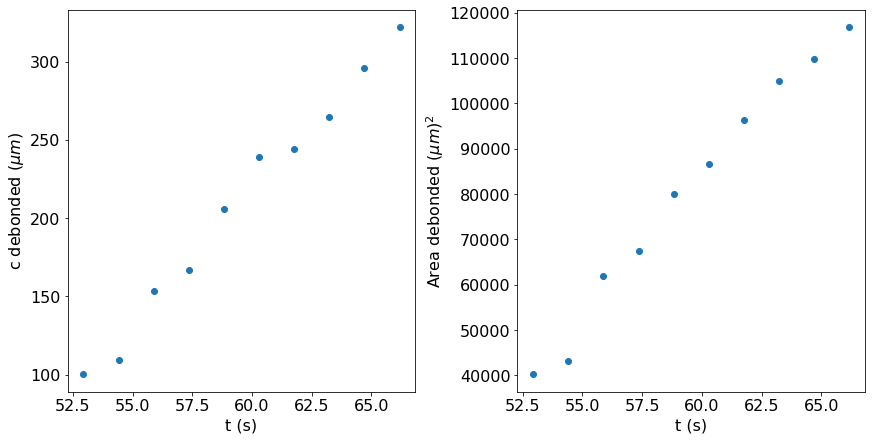

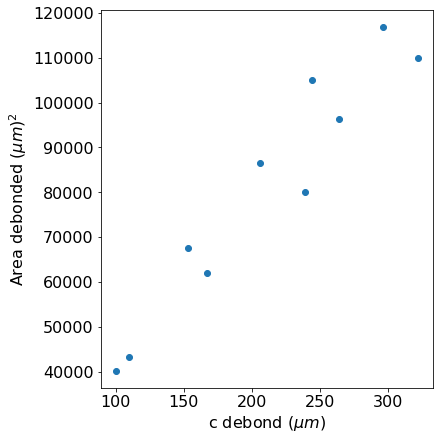

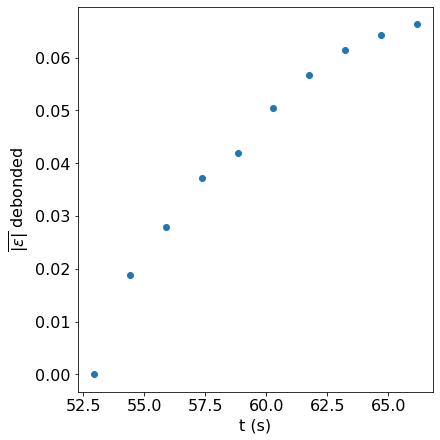

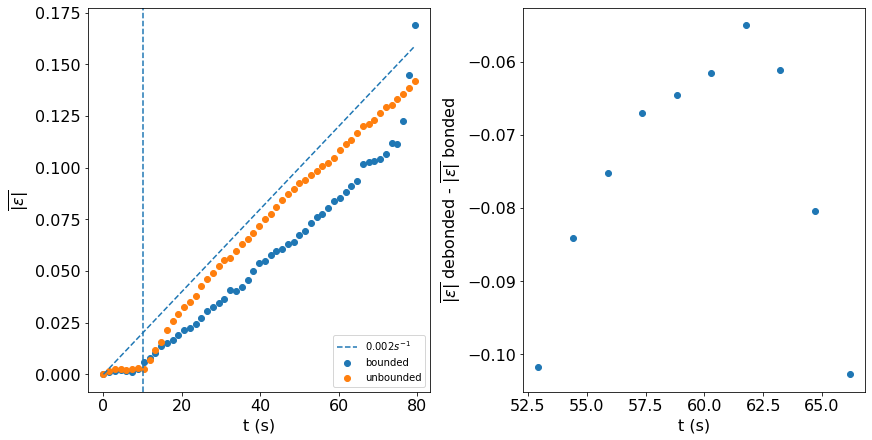

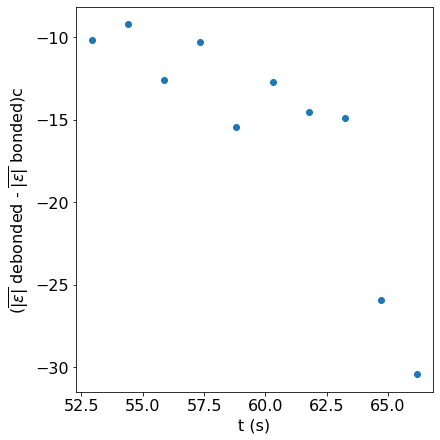

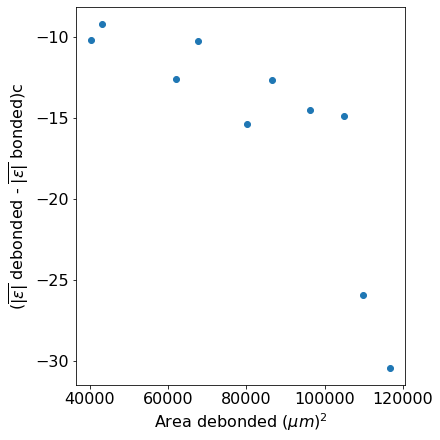

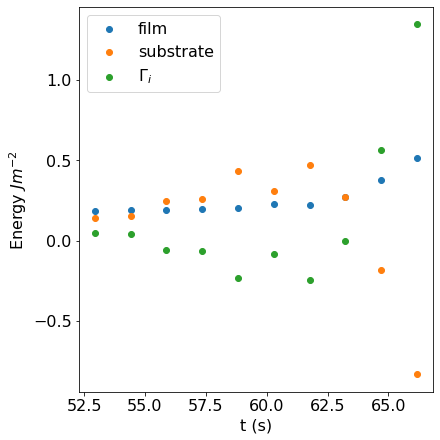

In [81]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

FPS_camera = 0.68

# Directory where the output files are saved
save_dir = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8"


lengths_file = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\camera_polygon\lengths_try2.txt"
areas_file = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\camera_polygon\polygon_areas_try_2.txt"
strain_avg_debond = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8\debonded_average_strain.txt"
strain_avg_bond = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8\average_strain_in_square_bonded_t_o_w32_ol8.txt"
strain_avg_unbond = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8\average_strain_in_square_unbonded_t_o_w32_ol8.txt"


# Function to extract data from a file
def extract_data(filename):
    frame_numbers = []
    values = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split(': ')
            frame = int(parts[0].split()[1])
            value = float(parts[1].split()[0])
            frame_numbers.append(frame)
            values.append(value)
    return np.array(frame_numbers), np.array(values)

# Function to extract data from a file with a single floating-point value per line
def extract_single_value_data(filename):
    frame_numbers = []
    values = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split(': ')
            frame = int(parts[0].split()[1])
            value = float(parts[1])
            frame_numbers.append(frame)
            values.append(value)
    return np.array(frame_numbers), np.array(values)


# Extract length data
frame_numbers_length, lengths_microns = extract_data(lengths_file)

# Extract area data
frame_numbers_area, areas_microns = extract_data(areas_file)

# Extract strain average data for debonded
frame_numbers_strain_avg_db, strain_avg_values_db = extract_single_value_data(strain_avg_debond)

# Extract strain average data for bonded
frame_numbers_strain_avg_b, strain_avg_values_b = extract_single_value_data(strain_avg_bond)

# Extract strain average data for unbonded
frame_numbers_strain_avg_ub, strain_avg_values_ub = extract_single_value_data(strain_avg_unbond)

## for now I use the square of the strain_avg_values to get the strain energy 


# Plot the data
fig, axs = plt.subplots(1,2,figsize=(12, 6), constrained_layout = True)
# Plot lengths
axs[0].scatter(frame_numbers_length/0.68, lengths_microns)
axs[0].set_xlabel('t (s)', fontsize = 16)
axs[0].set_ylabel('c debonded ($\mu m$)', fontsize = 16)
#plt.title('Length vs Frame Number')
# Plot areas
axs[1].scatter(frame_numbers_area/0.68, areas_microns)
axs[1].set_xlabel('t (s)', fontsize = 16)
axs[1].set_ylabel('Area debonded $(\mu m)^2$', fontsize = 16)
#plt.title('Area vs Frame Number', fontsize = 16)
for ax in axs:
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)
    #ax.legend(fontsize = 16)
fig.savefig(os.path.join(save_dir,"20240415_RTV615_box1_scotch3_test_1_camera_debond_area.png"))

fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)

axs.scatter(lengths_microns, areas_microns)
axs.set_xlabel('c debond ($\mu m$)', fontsize = 16)
axs.set_ylabel('Area debonded $(\mu m)^2$', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)
fig.savefig(os.path.join(save_dir,"20240415_RTV615_box1_scotch3_test_1_camera_debond_area_vs_length.png"))

fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(frame_numbers_strain_avg_db/0.68, strain_avg_values_db)
axs.set_xlabel('t (s)', fontsize = 16)
axs.set_ylabel(r'$\overline{|\epsilon|}$ debonded', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)
fig.savefig(os.path.join(save_dir,"20240415_RTV615_box1_scotch3_test_1_norm_strain_vs_time.png"))

rate = 0.002
fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
axs[0].scatter(frame_numbers_strain_avg_b/0.68, strain_avg_values_b, label = 'bounded')
axs[0].scatter(frame_numbers_strain_avg_ub/0.68, strain_avg_values_ub, label = 'unbounded')
axs[0].set_xlabel('t (s)', fontsize = 16)
axs[0].axvline(10, linestyle = '--')
axs[0].plot(frame_numbers_strain_avg_ub/0.68, rate*frame_numbers_strain_avg_ub/0.68, linestyle = '--', label = '$0.002 s^{-1}$')
axs[0].set_ylabel(r'$\overline{|\epsilon|}$ ', fontsize = 16)

axs[1].scatter(frame_numbers_strain_avg_db/0.68, strain_avg_values_db - strain_avg_values_b[-strain_avg_values_db.shape[0]:])
axs[1].set_xlabel('t (s)', fontsize = 16)
axs[1].set_ylabel(r'$\overline{|\epsilon|}$ debonded - $\overline{|\epsilon|}$ bonded', fontsize = 16)
for ax in axs:
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)
axs[0].legend()

fig.savefig(os.path.join(save_dir,"20240415_RTV615_box1_scotch3_test_1_strain_region.png"))
    
fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(frame_numbers_strain_avg_db/0.68, (strain_avg_values_db - strain_avg_values_b[-strain_avg_values_db.shape[0]:])*lengths_microns)
axs.set_xlabel('t (s)', fontsize = 16)
axs.set_ylabel(r'$(\overline{|\epsilon|}$ debonded - $\overline{|\epsilon|}$ bonded)c', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)

fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(areas_microns, (strain_avg_values_db - strain_avg_values_b[-strain_avg_values_db.shape[0]:])*lengths_microns)
axs.set_xlabel('Area debonded $(\mu m)^2$', fontsize = 16)
axs.set_ylabel(r'$(\overline{|\epsilon|}$ debonded - $\overline{|\epsilon|}$ bonded)c', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)

Ef = 1.2e6 # 1 MPa in Pa
f = 0.25 # Need to look into the instron data for this value definately less than 1
hf  = 90*1e-6 # 90 um
hs = 900*1e-6 #height of substrate m
nu_f = 0.5 #should be 0.3
nu_s = 0.5
Es = 0.5e6
hs = 1e-3
EE_s = Es*(((strain_avg_values_ub[-strain_avg_values_db.shape[0]:])**2 -(strain_avg_values_b[-strain_avg_values_db.shape[0]:])**2)*lengths_microns*1e-6)/(2*(1-nu_s**2))
#EE_s_2 = Es*(((strain_avg_values_ub[-strain_avg_values_db.shape[0]:])**2 -(strain_avg_values_b[-strain_avg_values_db.shape[0]:])**2)*hs)/(2*(1-nu_s**2))

EE_f = f*Ef*((strain_avg_values_b[-strain_avg_values_db.shape[0]:])**2)*hf/(2*(1-nu_f**2))



fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(frame_numbers_strain_avg_db/0.68, (EE_f), label = 'film')
axs.scatter(frame_numbers_strain_avg_db/0.68, (EE_s), label = 'substrate')
axs.scatter(frame_numbers_strain_avg_db/0.68, (EE_f-EE_s), label = '$\Gamma_{i}$ ')
#axs.scatter(frame_numbers_strain_avg_db/0.68, (EE_f-EE_s_2), label = '$\Gamma_{i} 2$ ')
                                                                                                                                          
print((EE_f-EE_s)*1e3)

print("The mean of adhesion energy is {} +/- {} mJ/m2".format(np.mean(EE_f[:2]-EE_s[:2])*1e3, np.std(EE_f[:2]-EE_s[:2])*1e3))

axs.set_xlabel('t (s)', fontsize = 16)
axs.set_ylabel(r'Energy $Jm^{-2}$', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)
axs.legend(fontsize = 16)
fig.savefig(os.path.join(save_dir,"20240415_RTV615_box1_scotch3_test_1_adhesion_energy.png"))

In [32]:
print(lengths_microns.shape, areas_microns.shape)

(23,) (25,)


# Rough Work

## The area and the length calculations are better for try_2 in the file ws32_ol8.  Regarding the values, there is a difference from ws32ol8 to ws32ol16. Which one to choose?

C:\Users\AKASHS~1\AppData\Local\Temp/ipykernel_18608/1938527871.py:18: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  im_overlay = label2rgb(labeled_image_1, imgray)


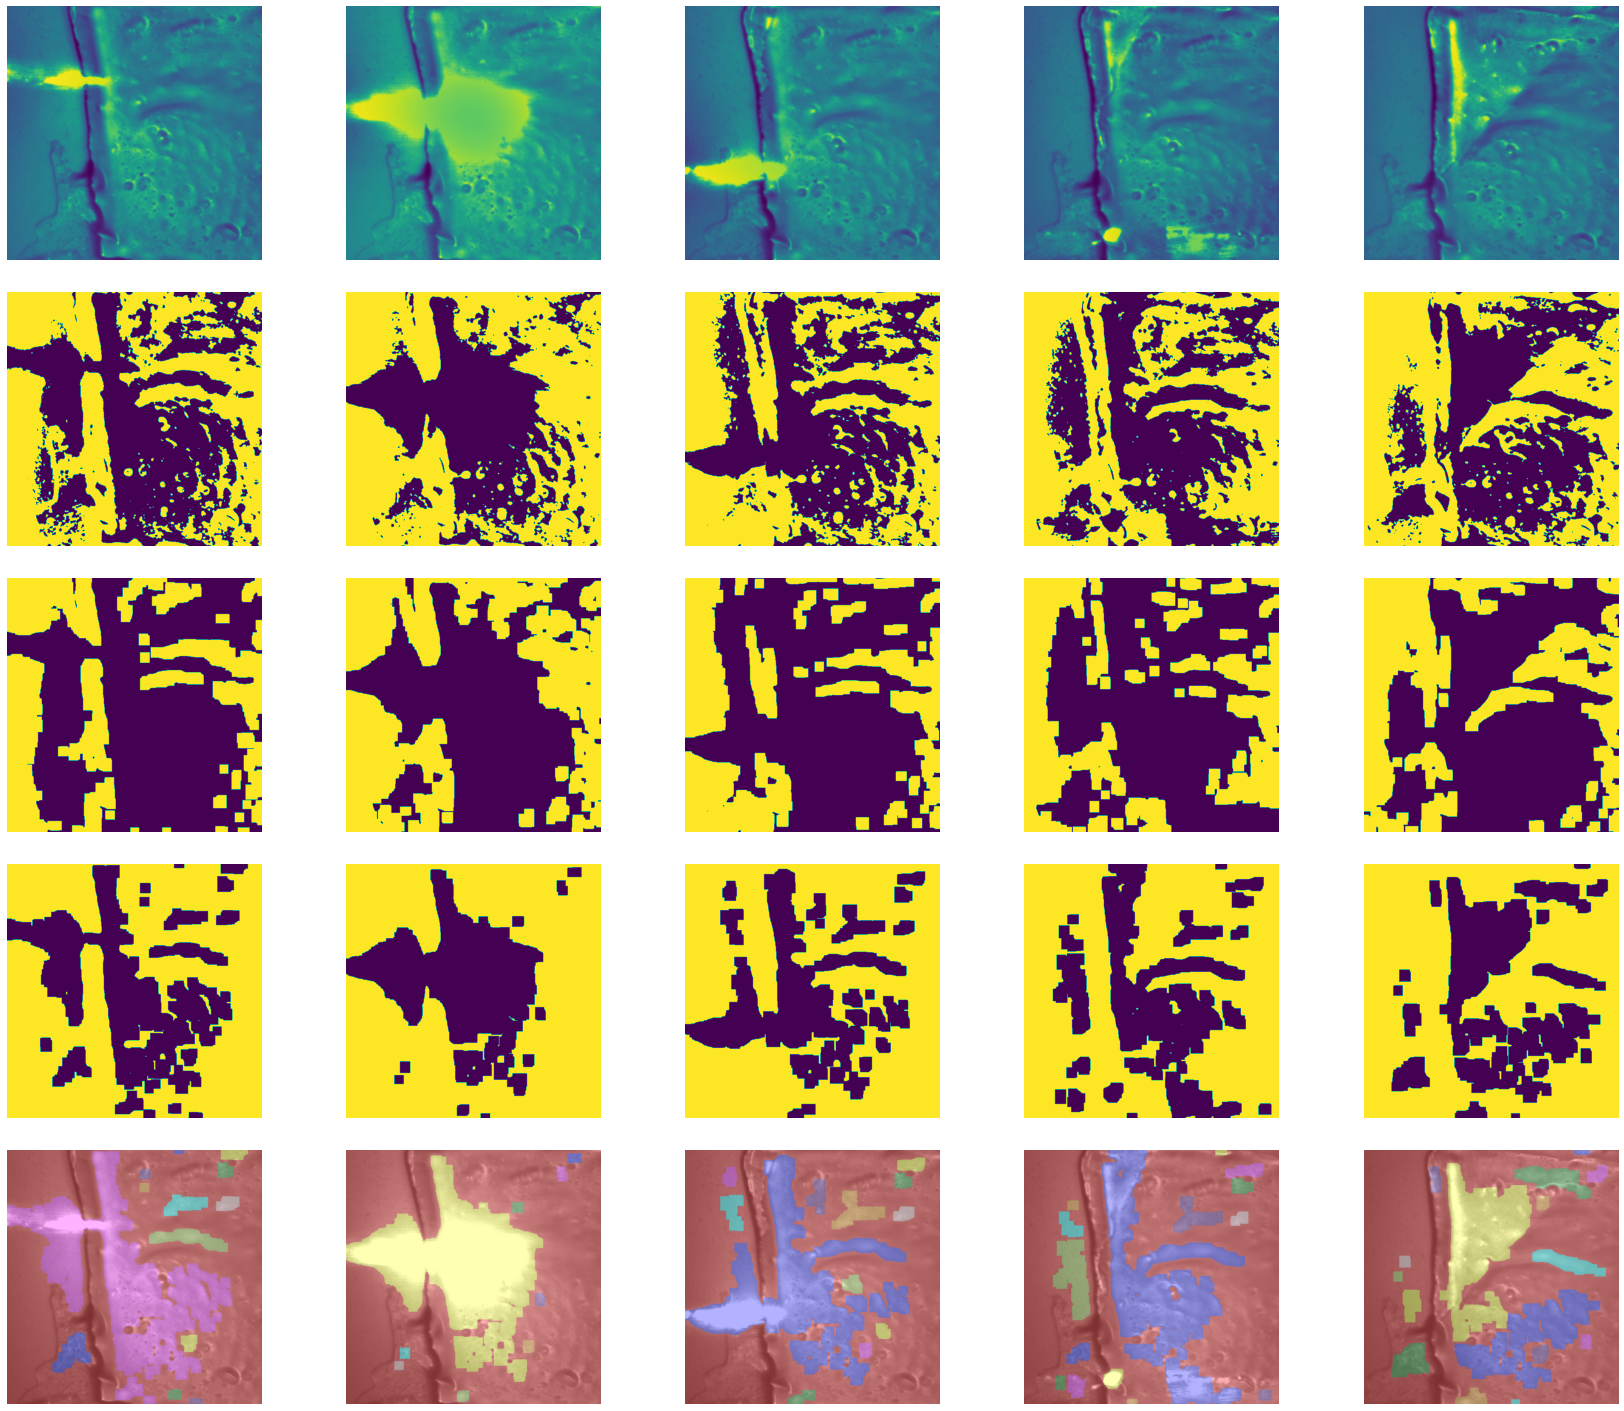

In [30]:
size = 21
size1 = 21
images = np.array([20,25,35, 45,60])
fig, axs = plt.subplots(5,5, figsize = (24,20))
for i, image in enumerate(images):
    #im = cv.imread(r'D:\ESPCI\Experiments\Product+PDS\20220516\VCXU-32M_700002909206_220516-174043\20220516_t_z{:04d}.tif'.format(image))
    im = cv.imreadmulti(r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\cropped_VCXU-32M_700002909206_240515-155124.tif")
    imgray = cv.cvtColor(im[1][image], cv.COLOR_BGR2GRAY)
    fil_im = gaussian_filter(imgray-gaussian_filter(imgray.astype(float), 101),1)
    thresh = cv.adaptiveThreshold(fil_im.astype('uint8'), 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 501, 1)
    thresh_closing = morphology.binary_closing(thresh, np.ones((size,size)))
    thresh_opening = morphology.binary_opening(thresh, np.ones((size1,size1)))
    axs[0,i].imshow(fil_im)
    axs[1,i].imshow(thresh)
    axs[2,i].imshow(thresh_opening)
    axs[3,i].imshow(thresh_closing)
    labeled_image_1 = measure.label(thresh_closing.astype('uint8'), background=1)
    im_overlay = label2rgb(labeled_image_1, imgray)
    axs[4,i].imshow(im_overlay)
    
    
plt.tight_layout()
for ax in axs.flatten():
    ax.axis('off')

C:\Users\AKASHS~1\AppData\Local\Temp/ipykernel_18608/3069825365.py:18: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  im_overlay = label2rgb(labeled_image_1, imgray)


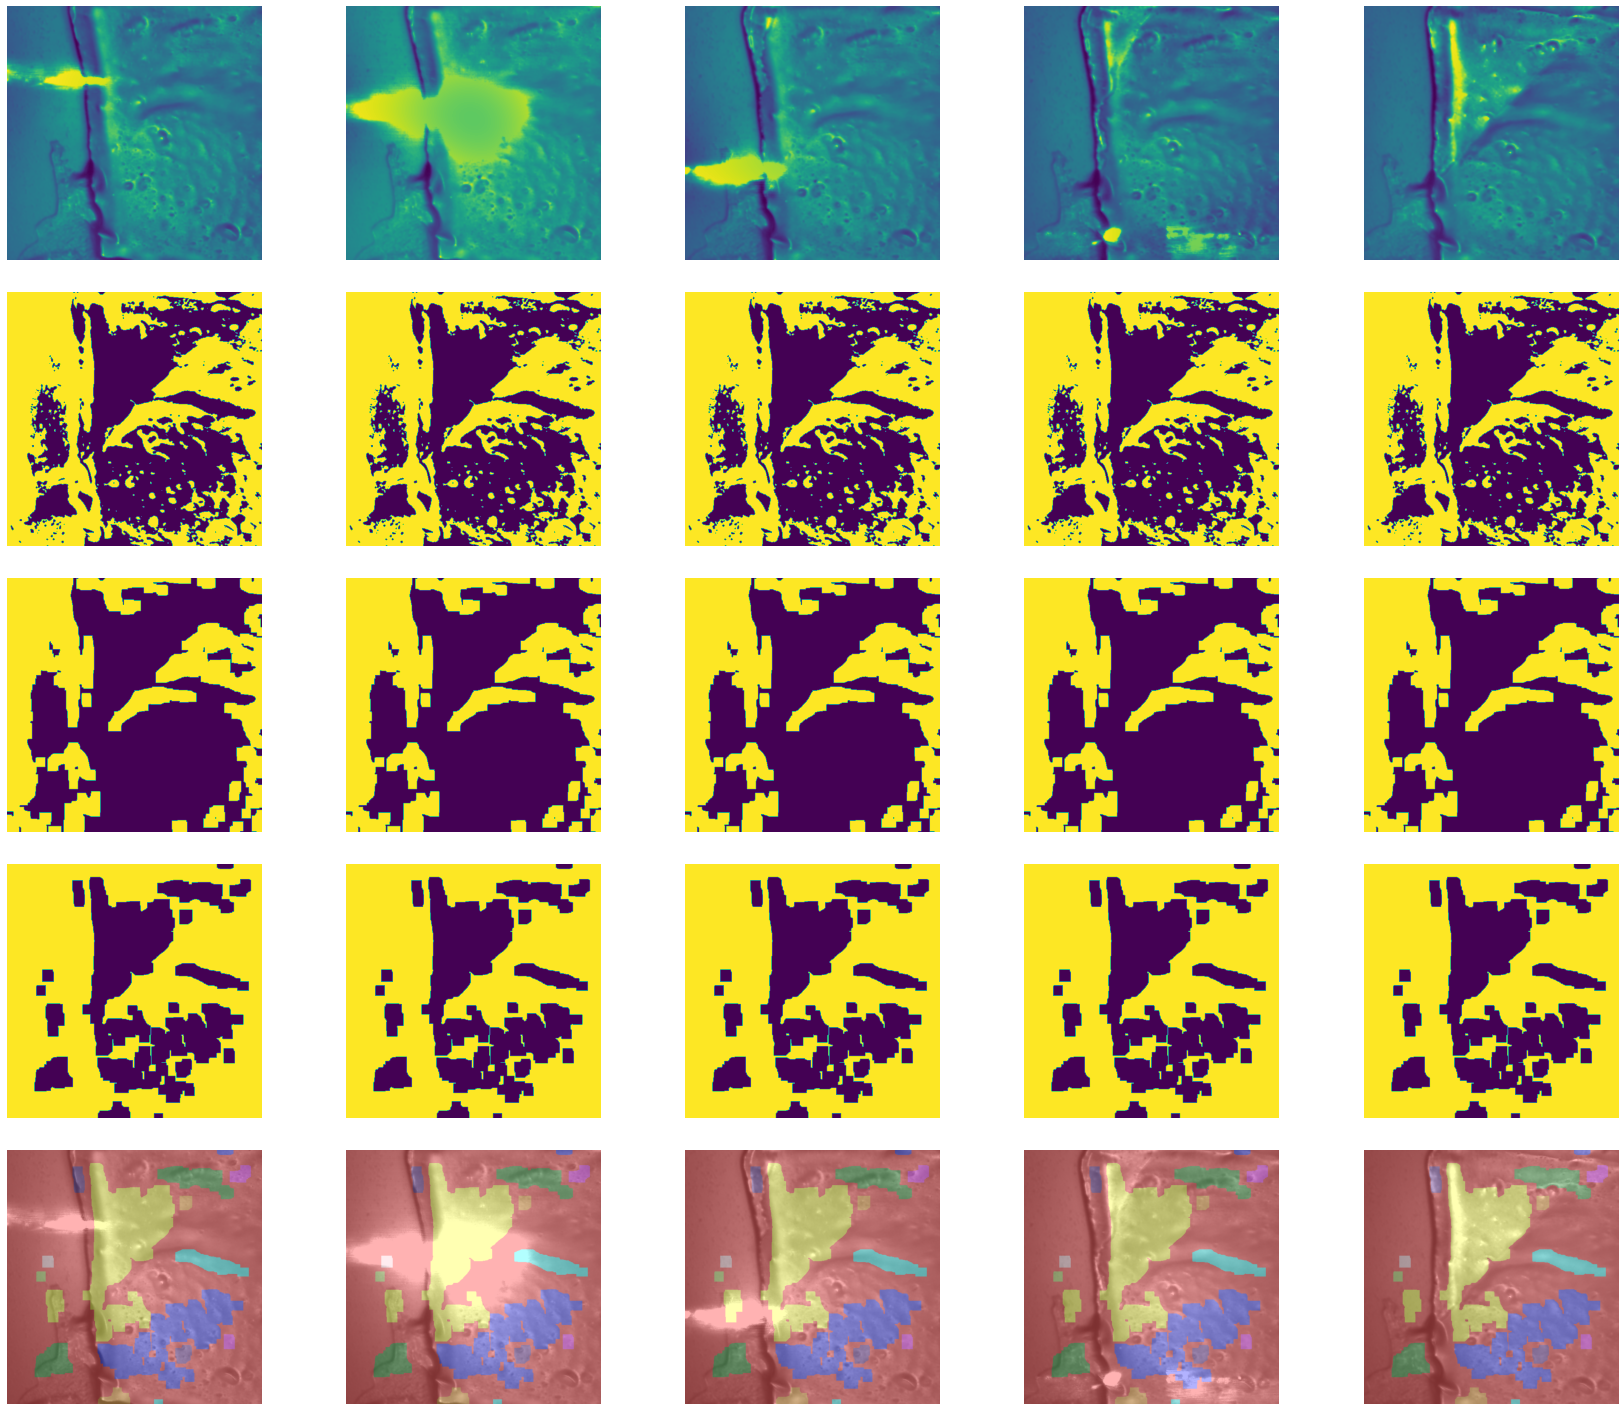

In [31]:
size = 21
images = np.array([20,25,35, 45,60])
fig, axs = plt.subplots(5,5, figsize = (24,20))
for i, image in enumerate(images):
    #im = cv.imread(r'D:\ESPCI\Experiments\Product+PDS\20220516\VCXU-32M_700002909206_220516-174043\20220516_t_z{:04d}.tif'.format(image))
    im = cv.imreadmulti(r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\cropped_VCXU-32M_700002909206_240515-155124.tif")
    imgray = cv.cvtColor(im[1][image], cv.COLOR_BGR2GRAY)
    fil_im = gaussian_filter(imgray-gaussian_filter(imgray.astype(float), 101),1)
    thresh1 = threshold_multiotsu(fil_im, classes = 3)
    regions =2 + util.invert(np.digitize(fil_im, thresh1))
    thresh_closing_1 = morphology.binary_closing(regions, np.ones((size,size)))
    thresh_opening_1 = morphology.binary_opening(regions, np.ones((size,size)))
    
    axs[0,i].imshow(fil_im)
    axs[1,i].imshow(thresh)
    axs[2,i].imshow(thresh_opening)
    axs[3,i].imshow(thresh_closing)
    labeled_image_1 = measure.label(thresh_closing.astype('uint8'), background=1)
    im_overlay = label2rgb(labeled_image_1, imgray)
    axs[4,i].imshow(im_overlay)
    
    
plt.tight_layout()
for ax in axs.flatten():
    ax.axis('off')

In [35]:
thresholds

array([10.02926725])

In [37]:
2+util.invert(np.digitize(fil_im, thresholds))

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int64)

## The above all calculations are for ws 32 and ol 16. I will do the calculation for ws 32 and ol 8 below

[  159.77916959   167.17789137   172.81521153   190.95312229
   186.73592208   207.6426225    190.4794041    197.63249244
   169.78006058   161.74496097   171.60498234   172.42285963
   148.41904741   173.66065491   137.00623911   136.69032244
   151.909138     125.98015147    -4.04805199   -24.001594
  -146.54616578   -81.66280237  -205.4679704   -195.63692865
  -153.48659201  -314.55326938  -470.18876828  -425.83373464
  -590.37520549  -387.8303022   -599.49500698  -744.53484593
  -967.34103709 -1048.85053223 -1991.36761217 -1783.49730385]
The mean of adhesion energy is 170.3796530178137 +/- 19.58110911627499 mJ/m2


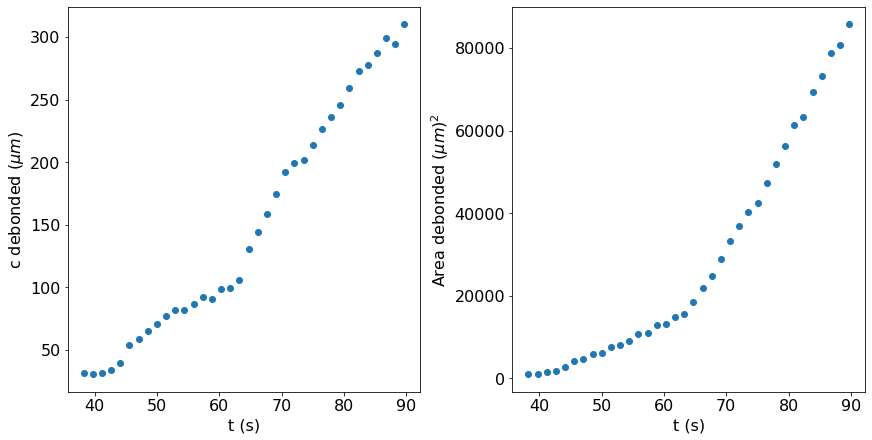

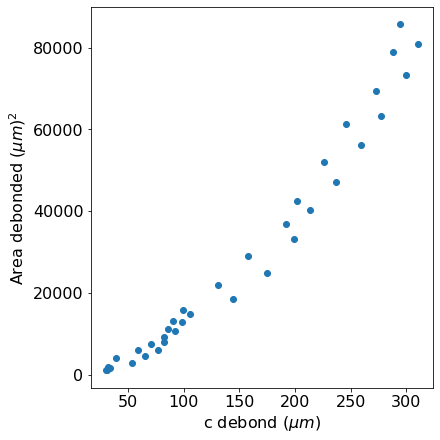

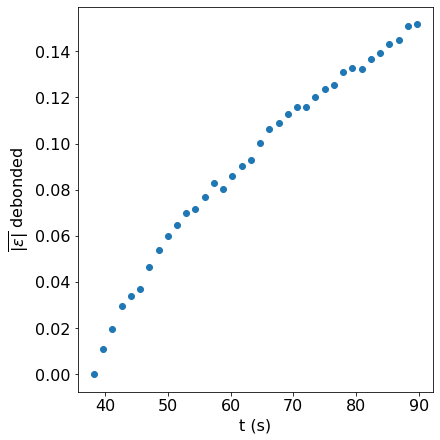

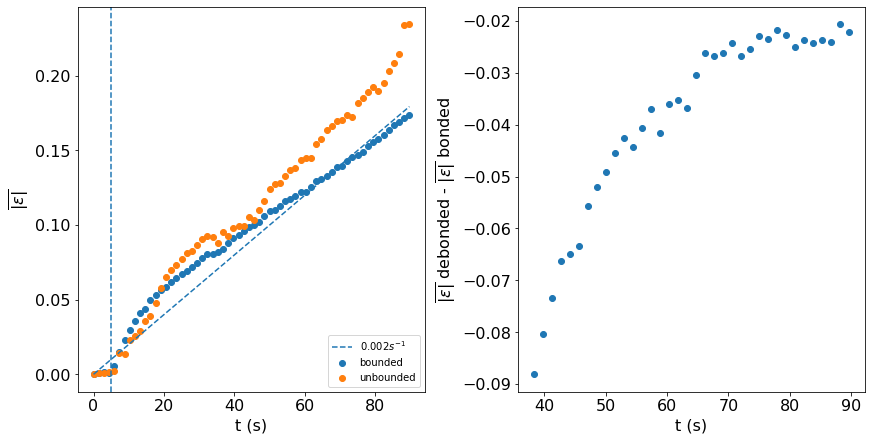

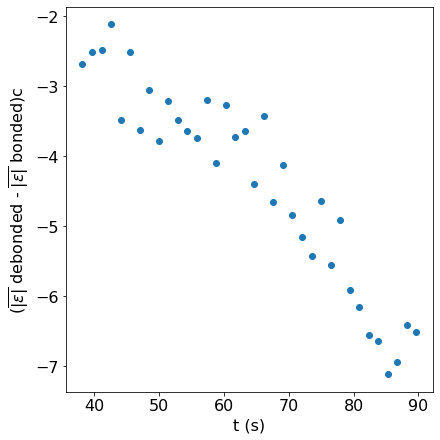

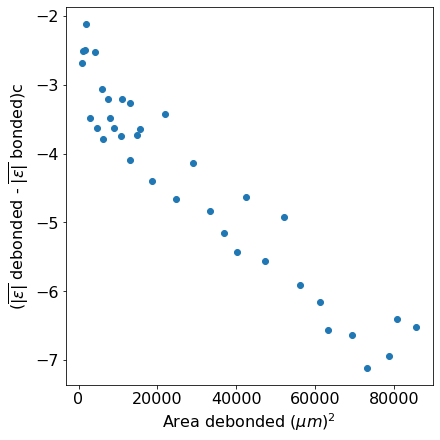

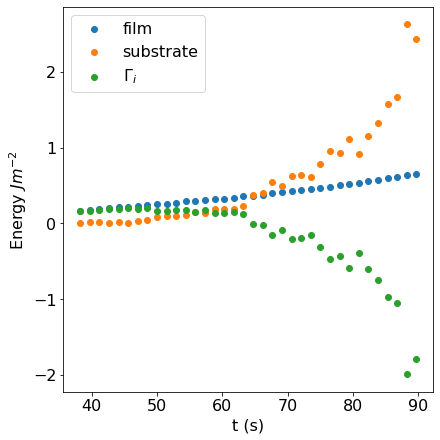

In [22]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

FPS_camera = 0.68

# Directory where the output files are saved
save_dir = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16"

# Filenames of the data files
lengths_file = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8\camera_polygon\lengths_try2.txt"
areas_file = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8\camera_polygon\polygon_areas_try_2.txt"
#lengths_file = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\camera_polygon\lengths.txt"
#areas_file = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\camera_polygon\polygon_areas.txt"
strain_avg_debond = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8\average_strain.txt"
strain_avg_bond = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8\average_strain_in_square_bonded_t_o_w32_ol8.txt"
strain_avg_unbond = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8\average_strain_in_square_unbonded_t_o_w32_ol8.txt"
### strain_square_avg_debond  = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\average_strain_energy.txt"

# Function to extract data from a file
def extract_data(filename):
    frame_numbers = []
    values = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split(': ')
            frame = int(parts[0].split()[1])
            value = float(parts[1].split()[0])
            frame_numbers.append(frame)
            values.append(value)
    return np.array(frame_numbers), np.array(values)

# Function to extract data from a file with a single floating-point value per line
def extract_single_value_data(filename):
    frame_numbers = []
    values = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split(': ')
            frame = int(parts[0].split()[1])
            value = float(parts[1])
            frame_numbers.append(frame)
            values.append(value)
    return np.array(frame_numbers), np.array(values)


# Extract length data
frame_numbers_length, lengths_microns = extract_data(lengths_file)

# Extract area data
frame_numbers_area, areas_microns = extract_data(areas_file)

# Extract strain average data for debonded
frame_numbers_strain_avg_db, strain_avg_values_db = extract_single_value_data(strain_avg_debond)

# Extract strain average data for bonded
frame_numbers_strain_avg_b, strain_avg_values_b = extract_single_value_data(strain_avg_bond)

# Extract strain average data for unbonded
frame_numbers_strain_avg_ub, strain_avg_values_ub = extract_single_value_data(strain_avg_unbond)

## for now I use the square of the strain_avg_values to get the strain energy 



# Plot the data
fig, axs = plt.subplots(1,2,figsize=(12, 6), constrained_layout = True)
# Plot lengths
axs[0].scatter(frame_numbers_length/0.68, lengths_microns)
axs[0].set_xlabel('t (s)', fontsize = 16)
axs[0].set_ylabel('c debonded ($\mu m$)', fontsize = 16)
#plt.title('Length vs Frame Number')
# Plot areas
axs[1].scatter(frame_numbers_area/0.68, areas_microns)
axs[1].set_xlabel('t (s)', fontsize = 16)
axs[1].set_ylabel('Area debonded $(\mu m)^2$', fontsize = 16)
#plt.title('Area vs Frame Number', fontsize = 16)
for ax in axs:
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)
    #ax.legend(fontsize = 16)
fig.savefig(os.path.join(save_dir,"20240415_RTV615_box2_scotch3_test_1_camera_debond_area.png"))

fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(lengths_microns, areas_microns)
axs.set_xlabel('c debond ($\mu m$)', fontsize = 16)
axs.set_ylabel('Area debonded $(\mu m)^2$', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)
fig.savefig(os.path.join(save_dir,"20240415_RTV615_box2_scotch3_test_1_camera_debond_area_vs_length.png"))

fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(frame_numbers_strain_avg_db/0.68, strain_avg_values_db)
axs.set_xlabel('t (s)', fontsize = 16)
axs.set_ylabel(r'$\overline{|\epsilon|}$ debonded', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)
fig.savefig(os.path.join(save_dir,"20240415_RTV615_box2_scotch3_test_1_norm_strain_vs_time.png"))

rate = 0.002
fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
axs[0].scatter(frame_numbers_strain_avg_b/0.68, strain_avg_values_b, label = 'bounded')
axs[0].scatter(frame_numbers_strain_avg_ub/0.68, strain_avg_values_ub, label = 'unbounded')
axs[0].set_xlabel('t (s)', fontsize = 16)
axs[0].axvline(5, linestyle = '--')
axs[0].plot(frame_numbers_strain_avg_ub/0.68, rate*frame_numbers_strain_avg_ub/0.68, linestyle = '--', label = '$0.002 s^{-1}$')
axs[0].set_ylabel(r'$\overline{|\epsilon|}$ ', fontsize = 16)

axs[1].scatter(frame_numbers_strain_avg_db/0.68, strain_avg_values_db - strain_avg_values_b[-strain_avg_values_db.shape[0]:])
axs[1].set_xlabel('t (s)', fontsize = 16)
axs[1].set_ylabel(r'$\overline{|\epsilon|}$ debonded - $\overline{|\epsilon|}$ bonded', fontsize = 16)
for ax in axs:
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)
axs[0].legend()

fig.savefig(os.path.join(save_dir,"20240415_RTV615_box2_scotch3_test_1_strain_region.png"))
    
fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(frame_numbers_strain_avg_db/0.68, (strain_avg_values_db - strain_avg_values_b[-strain_avg_values_db.shape[0]:])*lengths_microns)
axs.set_xlabel('t (s)', fontsize = 16)
axs.set_ylabel(r'$(\overline{|\epsilon|}$ debonded - $\overline{|\epsilon|}$ bonded)c', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)

fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(areas_microns, (strain_avg_values_db - strain_avg_values_b[-strain_avg_values_db.shape[0]:])*lengths_microns)
axs.set_xlabel('Area debonded $(\mu m)^2$', fontsize = 16)
axs.set_ylabel(r'$(\overline{|\epsilon|}$ debonded - $\overline{|\epsilon|}$ bonded)c', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)

Ef = 1.2e6 # 1 MPa in Pa
f = 0.3 # Need to look into the instron data for this value definately less than 1
hf  = 90*1e-6 # 90 um
hs = 900*1e-6 #height of substrate m
nu_f = 0.5 #should be 0.3
nu_s = 0.5
Es = 0.5e6
hs = 1e-3
EE_s = Es*(((strain_avg_values_ub[-strain_avg_values_db.shape[0]:])**2 -(strain_avg_values_b[-strain_avg_values_db.shape[0]:])**2)*lengths_microns*1e-6)/(2*(1-nu_s**2))
#EE_s_2 = Es*(((strain_avg_values_ub[-strain_avg_values_db.shape[0]:])**2 -(strain_avg_values_b[-strain_avg_values_db.shape[0]:])**2)*hs)/(2*(1-nu_s**2))

EE_f = f*Ef*((strain_avg_values_b[-strain_avg_values_db.shape[0]:])**2)*hf/(2*(1-nu_f**2))





fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(frame_numbers_strain_avg_db/0.68, (EE_f), label = 'film')
axs.scatter(frame_numbers_strain_avg_db/0.68, (EE_s), label = 'substrate')
axs.scatter(frame_numbers_strain_avg_db/0.68, (EE_f-EE_s), label = '$\Gamma_{i}$ ')

                                                                                                                                          
print((EE_f-EE_s)*1e3)

print("The mean of adhesion energy is {} +/- {} mJ/m2".format(np.mean(EE_f[:17]-EE_s[:17])*1e3, np.std(EE_f[:17]-EE_s[:17])*1e3))

axs.set_xlabel('t (s)', fontsize = 16)
axs.set_ylabel(r'Energy $Jm^{-2}$', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)
axs.legend(fontsize = 16)
fig.savefig(os.path.join(save_dir,"20240415_RTV615_box2_scotch3_test_1_adhesion_energy.png"))

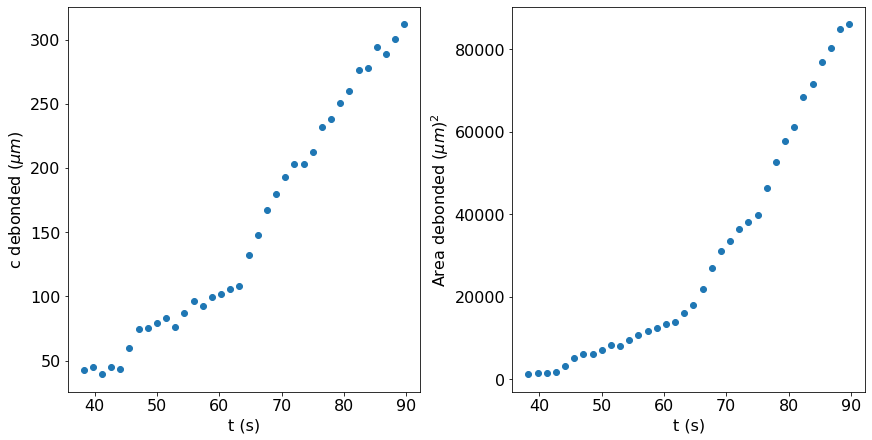

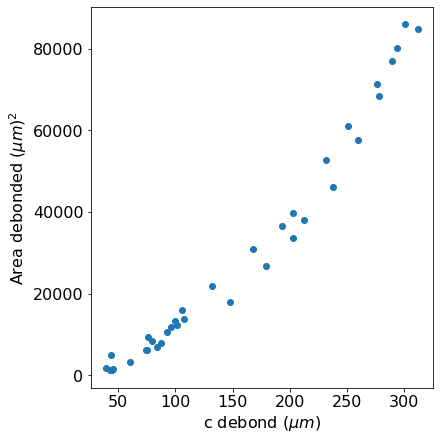

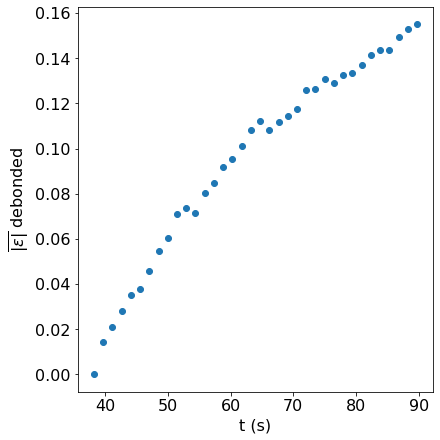

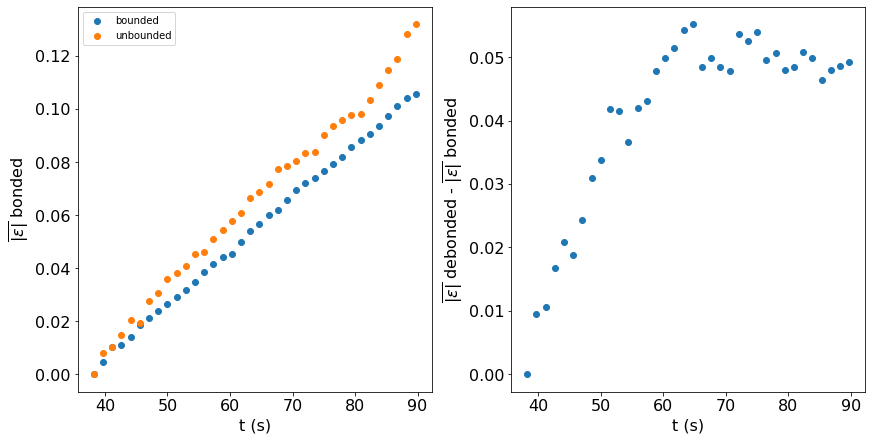

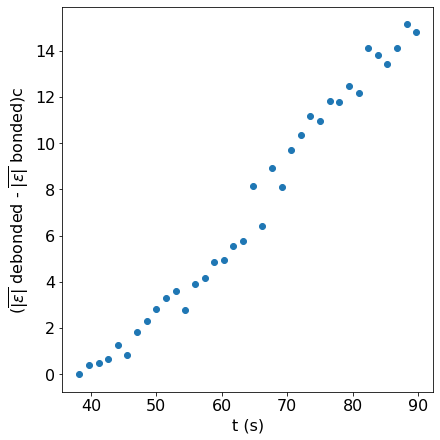

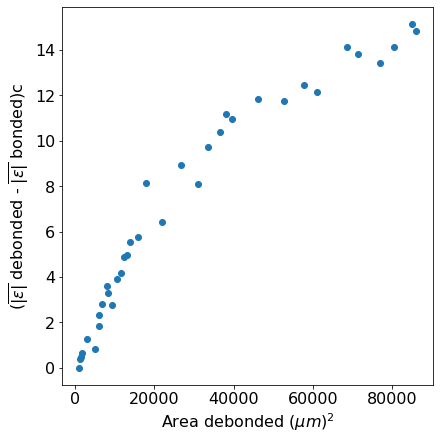

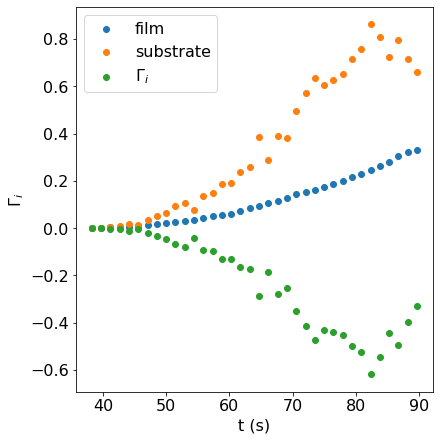

In [6]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

FPS_camera = 0.68

# Directory where the output files are saved
save_dir = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16"

# Filenames of the data files
lengths_file = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\camera_polygon\lengths.txt"
areas_file = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\camera_polygon\polygon_areas.txt"
strain_avg_debond = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\average_strain.txt"
strain_avg_bond = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\average_strain_in_square_bonded.txt"
strain_avg_unbond = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\average_strain_in_square_unbonded.txt"
### strain_square_avg_debond  = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\average_strain_energy.txt"

# Function to extract data from a file
def extract_data(filename):
    frame_numbers = []
    values = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split(': ')
            frame = int(parts[0].split()[1])
            value = float(parts[1].split()[0])
            frame_numbers.append(frame)
            values.append(value)
    return np.array(frame_numbers), np.array(values)

# Function to extract data from a file with a single floating-point value per line
def extract_single_value_data(filename):
    frame_numbers = []
    values = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split(': ')
            frame = int(parts[0].split()[1])
            value = float(parts[1])
            frame_numbers.append(frame)
            values.append(value)
    return np.array(frame_numbers), np.array(values)


# Extract length data
frame_numbers_length, lengths_microns = extract_data(lengths_file)

# Extract area data
frame_numbers_area, areas_microns = extract_data(areas_file)

# Extract strain average data for debonded
frame_numbers_strain_avg_db, strain_avg_values_db = extract_single_value_data(strain_avg_debond)

# Extract strain average data for bonded
frame_numbers_strain_avg_b, strain_avg_values_b = extract_single_value_data(strain_avg_bond)

# Extract strain average data for unbonded
frame_numbers_strain_avg_ub, strain_avg_values_ub = extract_single_value_data(strain_avg_unbond)

## for now I use the square of the strain_avg_values to get the strain energy 



# Plot the data
fig, axs = plt.subplots(1,2,figsize=(12, 6), constrained_layout = True)
# Plot lengths
axs[0].scatter(frame_numbers_length/0.68, lengths_microns)
axs[0].set_xlabel('t (s)', fontsize = 16)
axs[0].set_ylabel('c debonded ($\mu m$)', fontsize = 16)
#plt.title('Length vs Frame Number')
# Plot areas
axs[1].scatter(frame_numbers_area/0.68, areas_microns)
axs[1].set_xlabel('t (s)', fontsize = 16)
axs[1].set_ylabel('Area debonded $(\mu m)^2$', fontsize = 16)
#plt.title('Area vs Frame Number', fontsize = 16)
for ax in axs:
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)
    #ax.legend(fontsize = 16)
fig.savefig(os.path.join(save_dir,"20240415_RTV615_box2_scotch3_test_1_camera_debond_area.png"))

fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(lengths_microns, areas_microns)
axs.set_xlabel('c debond ($\mu m$)', fontsize = 16)
axs.set_ylabel('Area debonded $(\mu m)^2$', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)
fig.savefig(os.path.join(save_dir,"20240415_RTV615_box2_scotch3_test_1_camera_debond_area_vs_length.png"))

fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(frame_numbers_strain_avg_db/0.68, strain_avg_values_db)
axs.set_xlabel('t (s)', fontsize = 16)
axs.set_ylabel(r'$\overline{|\epsilon|}$ debonded', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)
fig.savefig(os.path.join(save_dir,"20240415_RTV615_box2_scotch3_test_1_norm_strain_vs_time.png"))

fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
axs[0].scatter(frame_numbers_strain_avg_b/0.68, strain_avg_values_b, label = 'bounded')
axs[0].scatter(frame_numbers_strain_avg_ub/0.68, strain_avg_values_ub, label = 'unbounded')
axs[0].set_xlabel('t (s)', fontsize = 16)
axs[0].set_ylabel(r'$\overline{|\epsilon|}$ bonded', fontsize = 16)

axs[1].scatter(frame_numbers_strain_avg_b/0.68, strain_avg_values_db - strain_avg_values_b)
axs[1].set_xlabel('t (s)', fontsize = 16)
axs[1].set_ylabel(r'$\overline{|\epsilon|}$ debonded - $\overline{|\epsilon|}$ bonded', fontsize = 16)
for ax in axs:
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)
axs[0].legend()
    
fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(frame_numbers_strain_avg_db/0.68, (strain_avg_values_db - strain_avg_values_b)*lengths_microns)
axs.set_xlabel('t (s)', fontsize = 16)
axs.set_ylabel(r'$(\overline{|\epsilon|}$ debonded - $\overline{|\epsilon|}$ bonded)c', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)

fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(areas_microns, (strain_avg_values_db - strain_avg_values_b)*lengths_microns)
axs.set_xlabel('Area debonded $(\mu m)^2$', fontsize = 16)
axs.set_ylabel(r'$(\overline{|\epsilon|}$ debonded - $\overline{|\epsilon|}$ bonded)c', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)

Ef = 1.2e6 # 1 MPa in Pa
f = 0.5
hf  = 90*1e-6 # 90 um
nu_f = 0.3
nu_s = 0.5
Es = 0.5e6
hs = 1e-3
EE_s = Es*((strain_avg_values_db**2 - strain_avg_values_ub**2)*lengths_microns*1e-6)/(2*(1-nu_s**2))
EE_f = f*Ef*(strain_avg_values_b**2)*hf/(2*(1-nu_f**2))

fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(frame_numbers_strain_avg_db/0.68, (EE_f), label = 'film')
axs.scatter(frame_numbers_strain_avg_db/0.68, (EE_s), label = 'substrate')
axs.scatter(frame_numbers_strain_avg_db/0.68, (EE_f-EE_s), label = '$\Gamma_i$')
axs.set_xlabel('t (s)', fontsize = 16)
axs.set_ylabel(r'$\Gamma_i$', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)
axs.legend(fontsize = 16)

## Negative adhesion energy! What am I missing?
- Can be due to incorrect strain field in the debonded section--> can change parameters to recalculate such as overlap size and others
- Physically I am adding in the the value of strain from $\Gamma$ substrate since once free the part unbonded deforms by this rather than $\Gamma$ film. Try to do the calculation step by step instead of accumulating from ti to t
- Take in values for a small region centrally in the countour and avoid edges?

## I understood the mistake! 
### The strain is supposed to be from t = 0 s for the film i.e. from the start of stretching so $\epsilon_b$ is supposed to be calculated from the start of the stretch (first assumption t = 0 frame but as seen in PIV calculation there is a bug in the calculation for the first 17 frames)
### EE_s = Es*((strain_avg_values_db**2 - strain_avg_values_ub**2)*lengths_microns*1e-6)/(2*(1-nu_s**2)) I am substracting the db with unbonded above for the substrate calculation which is a bg error because the debonded strain corresponds to this difference between the two! So the correct term should be EE_s = Es*((strain_avg_values_db**2 )*lengths_microns*1e-6)/(2*(1-nu_s**2))

[  154.05036336   164.7316723    168.13532574   172.37975204
   171.59265146   187.82205126   159.37270118   151.37619117
   132.8469378    121.84942072   112.32693942   135.74446551
    82.23764182    67.54496305    63.49368839    27.37350975
    11.91672789    27.37194838  -135.88276941   -91.64778873
  -305.80820346  -304.24798877  -432.13401159  -461.54283308
  -644.16238315  -592.49976448  -702.59345691  -785.78889759
  -953.01374764  -908.27105095 -1189.64282681 -1251.05647625
 -1322.90096772 -1522.06287464 -1710.02978203 -1631.77859362]


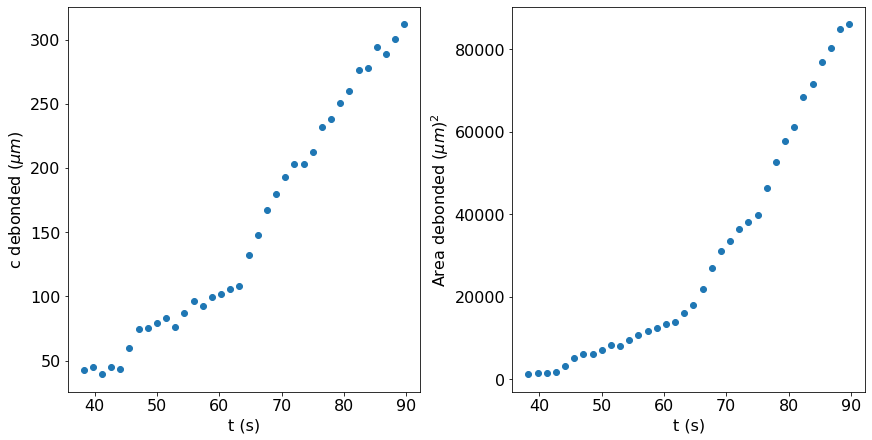

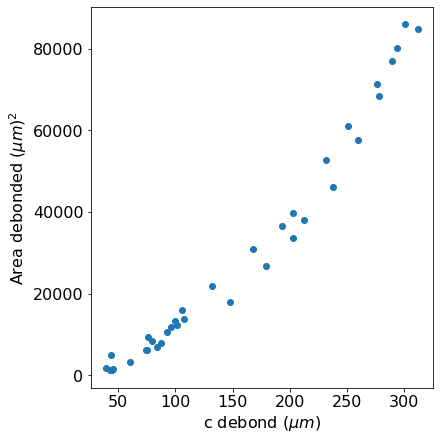

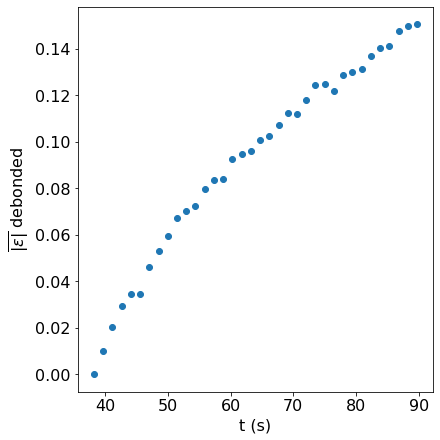

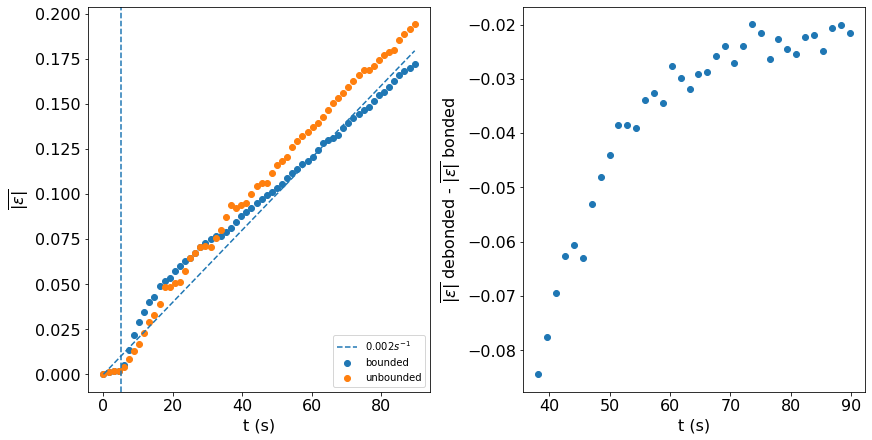

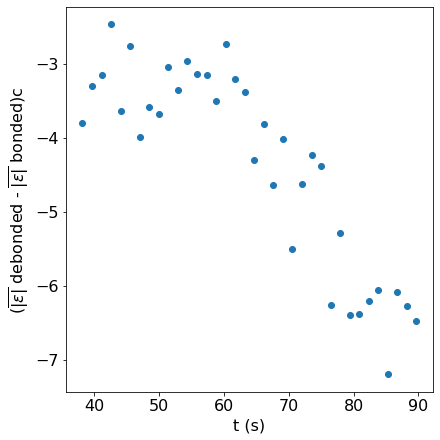

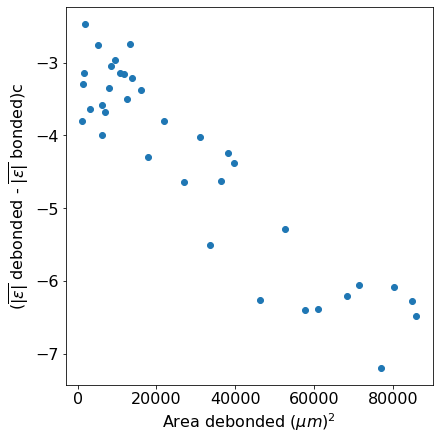

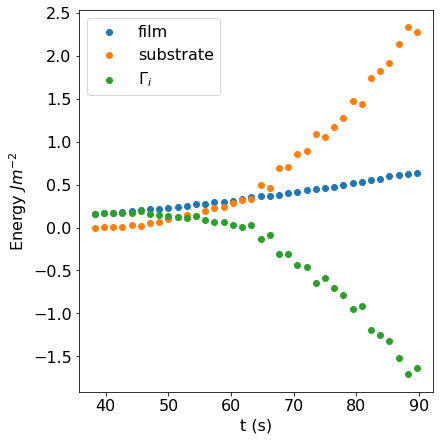

In [28]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

FPS_camera = 0.68

# Directory where the output files are saved
save_dir = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16"

# Filenames of the data files
lengths_file = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\camera_polygon\lengths.txt"
areas_file = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\camera_polygon\polygon_areas.txt"
strain_avg_debond = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_8\average_strain.txt"
strain_avg_bond = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\average_strain_in_square_bonded_t_o.txt"
strain_avg_unbond = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\average_strain_in_square_unbonded_t_o.txt"
### strain_square_avg_debond  = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\debonded_mask_analysis\mult3_ws32_os_16\average_strain_energy.txt"

# Function to extract data from a file
def extract_data(filename):
    frame_numbers = []
    values = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split(': ')
            frame = int(parts[0].split()[1])
            value = float(parts[1].split()[0])
            frame_numbers.append(frame)
            values.append(value)
    return np.array(frame_numbers), np.array(values)

# Function to extract data from a file with a single floating-point value per line
def extract_single_value_data(filename):
    frame_numbers = []
    values = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split(': ')
            frame = int(parts[0].split()[1])
            value = float(parts[1])
            frame_numbers.append(frame)
            values.append(value)
    return np.array(frame_numbers), np.array(values)


# Extract length data
frame_numbers_length, lengths_microns = extract_data(lengths_file)

# Extract area data
frame_numbers_area, areas_microns = extract_data(areas_file)

# Extract strain average data for debonded
frame_numbers_strain_avg_db, strain_avg_values_db = extract_single_value_data(strain_avg_debond)

# Extract strain average data for bonded
frame_numbers_strain_avg_b, strain_avg_values_b = extract_single_value_data(strain_avg_bond)

# Extract strain average data for unbonded
frame_numbers_strain_avg_ub, strain_avg_values_ub = extract_single_value_data(strain_avg_unbond)

## for now I use the square of the strain_avg_values to get the strain energy 



# Plot the data
fig, axs = plt.subplots(1,2,figsize=(12, 6), constrained_layout = True)
# Plot lengths
axs[0].scatter(frame_numbers_length/0.68, lengths_microns)
axs[0].set_xlabel('t (s)', fontsize = 16)
axs[0].set_ylabel('c debonded ($\mu m$)', fontsize = 16)
#plt.title('Length vs Frame Number')
# Plot areas
axs[1].scatter(frame_numbers_area/0.68, areas_microns)
axs[1].set_xlabel('t (s)', fontsize = 16)
axs[1].set_ylabel('Area debonded $(\mu m)^2$', fontsize = 16)
#plt.title('Area vs Frame Number', fontsize = 16)
for ax in axs:
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)
    #ax.legend(fontsize = 16)
fig.savefig(os.path.join(save_dir,"20240415_RTV615_box2_scotch3_test_1_camera_debond_area.png"))

fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(lengths_microns, areas_microns)
axs.set_xlabel('c debond ($\mu m$)', fontsize = 16)
axs.set_ylabel('Area debonded $(\mu m)^2$', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)
fig.savefig(os.path.join(save_dir,"20240415_RTV615_box2_scotch3_test_1_camera_debond_area_vs_length.png"))

fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(frame_numbers_strain_avg_db/0.68, strain_avg_values_db)
axs.set_xlabel('t (s)', fontsize = 16)
axs.set_ylabel(r'$\overline{|\epsilon|}$ debonded', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)
fig.savefig(os.path.join(save_dir,"20240415_RTV615_box2_scotch3_test_1_norm_strain_vs_time.png"))

rate = 0.002
fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
axs[0].scatter(frame_numbers_strain_avg_b/0.68, strain_avg_values_b, label = 'bounded')
axs[0].scatter(frame_numbers_strain_avg_ub/0.68, strain_avg_values_ub, label = 'unbounded')
axs[0].set_xlabel('t (s)', fontsize = 16)
axs[0].axvline(5, linestyle = '--')
axs[0].plot(frame_numbers_strain_avg_ub/0.68, rate*frame_numbers_strain_avg_ub/0.68, linestyle = '--', label = '$0.002 s^{-1}$')
axs[0].set_ylabel(r'$\overline{|\epsilon|}$ ', fontsize = 16)

axs[1].scatter(frame_numbers_strain_avg_db/0.68, strain_avg_values_db - strain_avg_values_b[-strain_avg_values_db.shape[0]:])
axs[1].set_xlabel('t (s)', fontsize = 16)
axs[1].set_ylabel(r'$\overline{|\epsilon|}$ debonded - $\overline{|\epsilon|}$ bonded', fontsize = 16)
for ax in axs:
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)
axs[0].legend()

fig.savefig(os.path.join(save_dir,"20240415_RTV615_box2_scotch3_test_1_strain_region.png"))
    
fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(frame_numbers_strain_avg_db/0.68, (strain_avg_values_db - strain_avg_values_b[-strain_avg_values_db.shape[0]:])*lengths_microns)
axs.set_xlabel('t (s)', fontsize = 16)
axs.set_ylabel(r'$(\overline{|\epsilon|}$ debonded - $\overline{|\epsilon|}$ bonded)c', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)

fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(areas_microns, (strain_avg_values_db - strain_avg_values_b[-strain_avg_values_db.shape[0]:])*lengths_microns)
axs.set_xlabel('Area debonded $(\mu m)^2$', fontsize = 16)
axs.set_ylabel(r'$(\overline{|\epsilon|}$ debonded - $\overline{|\epsilon|}$ bonded)c', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)

Ef = 1.2e6 # 1 MPa in Pa
f = 0.3 # Need to look into the instron data for this value definately less than 1
hf  = 90*1e-6 # 90 um
nu_f = 0.5 #should be 0.3
nu_s = 0.5
Es = 0.5e6
hs = 1e-3
EE_s = Es*((strain_avg_values_db**2)*lengths_microns*1e-6)/(2*(1-nu_s**2))
EE_f = f*Ef*((strain_avg_values_b[-strain_avg_values_db.shape[0]:])**2)*hf/(2*(1-nu_f**2))


fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
axs.scatter(frame_numbers_strain_avg_db/0.68, (EE_f), label = 'film')
axs.scatter(frame_numbers_strain_avg_db/0.68, (EE_s), label = 'substrate')
axs.scatter(frame_numbers_strain_avg_db/0.68, (EE_f-EE_s), label = '$\Gamma_{i}$ ')
print((EE_f-EE_s)*1e3)
axs.set_xlabel('t (s)', fontsize = 16)
axs.set_ylabel(r'Energy $Jm^{-2}$', fontsize = 16)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)
axs.legend(fontsize = 16)
fig.savefig(os.path.join(save_dir,"20240415_RTV615_box2_scotch3_test_1_adhesion_energy.png"))

### Now in the model I have the term $\epsilon^{2} - \epsilon^{2}_{f}$ for the substrate part. In the above calculation, I am substituting the term with $\epsilon_{db}^2$. But $\epsilon_{db} = \epsilon_{ub}- \epsilon_{b}$. Hence, the square will not be equal to  $\epsilon^{2} - \epsilon^{2}_{f}$. Hene I use the actual mean value of the  $\epsilon_{ub}$ and $\epsilon_{b}$
